# Inscriptions as data: digital epigraphy in macro-historical perspective 

### Petra Hermankova
Author. Aarhus University, [ORCID: 0000-0002-6349-0540](https://orcid.org/0000-0002-6349-0540)

### Vojtech Kase
Author. Aarhus University, [ORCID: 0000-0002-6601-1605](http://orcid.org/0000-0002-6601-1605)

### Adela Sobotkova
Author. Aarhus University, [ORCID:0000-0002-4541-3963](https://orcid.org/0000-0002-4541-3963)

**Abstract**

As short texts written on a durable medium, inscriptions represent invaluable insight into past societies, their organisation, cultural norms and practices. Several hundred thousand inscriptions in Greek and Latin language survived until today, providing us with a line of evidence concerning populations of large cities and rural communities of the entire Mediterranean Basin in the period between the eighth century BC and eighth century AD. Although data on inscriptions have been mostly digitized in online databases surrounded with ample digital tools, large-scale and comparative studies of inscriptions are still rare. Numerous technical and conceptual issues, such as inconsistent resolution of spatial and temporal attributes or variable provenance, hinder the aggregation and analysis of thousands of inscriptions. This article presents open-source tools and reproducible approaches we developed and applied to the aggregated digital epigraphic dataset before attempting an macro-scale overview of this incomplete, uncertain and complex historical source. We contrast and combine two well-established, yet very distinct, digital sources for Latin epigraphy: Epigraphic Database Heidelberg (EDH), containing over 81,000 records and Epigraphische Datenbank Clauss-Slaby (EDCS) with over 500,000 records. We compare long-term trends of epigraphic production generated from each of the two sources and discuss the caveats of large-scale studies based on incomplete and biased historical sources.

**Keywords**

digital epigraphy; quantitative research; FAIR science; reproducibility; digital history; Latin inscriptions; epigraphic production

**GitHub**

https://github.com/sdam-au/digital_epigraphy

**Data Source**

EDH dataset: https://sciencedata.dk/public/b6b6afdb969d378b70929e86e58ad975/EDH_text_cleaned_2021-01-21.json

EDCS dataset: https://sciencedata.dk/public/1f5f56d09903fe259c0906add8b3a55e/EDCS_text_cleaned_2021-03-01.json

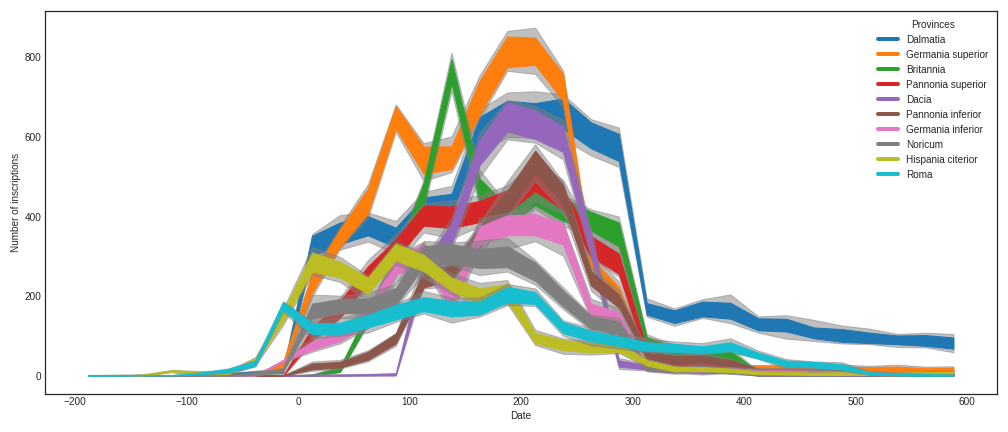

In [1]:
from IPython.display import Image, display
metadata = {
    "jdh": {
        "module": "object",
        "object": {
            "type": "image",
            "source": [
                "The trends of epigraphic production in Roman Provinces, based on Epigraphic Database Heidelberg dataset",
                "copyright 2021"
            ]
        }
    }
}
display(Image("Epigraphic_production_provinces_EDH.png"),
        metadata=metadata)  # test the placeholder cover image

### Notebook Configuration

In [1]:
%%capture
# install Python libraries
!pip install sddk tempun scipy seaborn nltk rpy2 cite2c geopandas cite2c
# alternatively:
#!pip install -r requirements.txt (eventually we can load reqs via requirements)

In [2]:
import geopandas as gpd
import cite2c
import requests
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import trapz
import scipy
import nltk
import json
import tempun
import sddk
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000  # to see all columns

In [4]:
# cite2c module for bibliographies

!pip install cite2c
!python3 -m cite2c.install

Installing nbextension ...
Enabling the nbextension ...
Enabling the server extension ...
Done.


## Introduction
Ancient inscriptions form an idiosyncratic category of evidence on past societies, straddling the divide between textual accounts and archaeological artefacts. Close-reading methods dominated early studies of inscriptions, with the aim to reconstruct the text, date and interpret the inscriptions. As the body of evidence grew, synthetic analyses started to emerge with the aim to investigate larger-scale patterns <cite data-cite="7109337/C5QVR3SE"></cite> <cite data-cite="7109337/AU6JTRIU"></cite> <cite data-cite="7109337/A6W7Q3HZ"></cite> <cite data-cite="7109337/IRUVQAYJ"></cite> <cite data-cite="7109337/TXCY5XL8"></cite>. **REF check: (MacMullen 1982; Meyer 1990; Woolf 1996; Hedrick 1999; Nawotka 2021)** Digitized epigraphic data made it possible to tackle topics such as the evolution of demographic trends, migration patterns, changes of the socio-political organisation and cultural development using distant-reading and other computational techniques <cite data-cite="7109337/BRZQ3MUL"></cite> <cite data-cite="7109337/L73K2ZRY"></cite> <cite data-cite="7109337/75PC3E2A"></cite> <cite data-cite="7109337/WZ6MD9YX"></cite> **REF check: (Wilson 2012; Wilson and Flohr 2016; de Light and Tacoma 2016; Hanson et al. 2017)**. While these computational studies underscore the potential of epigraphic evidence, they rarely use a dataset larger than several thousand records. Greek and Latin inscriptions, however, count hundreds of thousands spanning the Roman Empire spatially and temporally, and thus potentially form a source that can inform large-scale and long-term studies such as conducted by Ian Morris <cite data-cite="7109337/TGQ9TAPF"> </cite><cite data-cite="7109337/93X7WDDV"></cite> **REF check: (2010; 2013)**, the Seshat Project <cite data-cite="7109337/PE4PYNDX"></cite> <cite data-cite="7109337/2ASLDCJP"></cite> <cite data-cite="7109337/3L9BKAXW"></cite> **REF check: (Turchin and Scheidel 2009; Mullins et al. 2018; Turchin et al. 2018)** or Josiah Ober <cite data-cite="7109337/RB28J3CE"></cite> **REF check: (2015)**. 



<!--Manual checking of bibliography-->

<div class="cite2c-biblio"></div>

Currently such large-scale study has been beyond the reach of any individual researcher because of the gargantuan efforts of aggregating and streamlining the thousands of inscriptions to make analysis feasible. Even the exact number of ancient inscriptions, dating between 800 BC and 800 AD, currently estimated at 600,000 surviving Latin and Greek ones, remains elusive (Bodel 2001, 4; Beltran-Lloris 2014, 135). Although numerous analogue and digital corpora exist, their contents overlap to variable degree and are not straightforward to combine. Some collections focus on specific language, mostly Latin- or Greek-language inscriptions, others collate all inscriptions from a particular modern or ancient geographic area regardless of language, others yet focus on a particular chronological period. While the challenge of technical data wrangling and distant-reading the inscriptions may be beyond a single researcher, a collaborative team equipped with both the necessary computational tools and domain-specific skill set may get further. Working from established digital repositories and building our own digital toolkit on the go, we try to address the topic that has puzzled epigraphers for nearly a century: why some people in various times and places of Roman Empire commissioned inscriptions and some did not.

## Epigraphic Habit(s) 40 years later: can we do any better?
Inscriptions vary greatly in form and contents, touching almost all aspects of life in an ancient society. Commissioning an inscription was part of a long-term cultural practice that served as a physical response to a change of circumstances, i.e. death, birth, change of legal status, social rank, building activities etc. The form and content of an inscription reflected a set of existing social norms. The inscribed texts range from short private messages on objects of daily use to extensive regulations and codes issued by a political authority, to monumental inscriptions helping to create public image and build social prestige. In contrast with literary texts that were often preserved via the act of multiple copying and editing, the text of inscription has the original unaltered form with original typographical and grammatical errors, being an ideal study subject for historical linguists. Moreover, the information preserved via inscriptions potentially has a wider demographic coverage than literary texts, as inscriptions were produced by social groups of more diverse socio-economic and cultural background than those of literary texts (Bodard 2008).


Working at the level of the province with a couple thousand inscriptions at a time, scholars have started constructing regional diachronic overviews of epigraphic production. Comparative studies between North Africa, Gaul or Greece revealed that epigraphic production in these provinces follows the same diachronic pattern. Inscription numbers peak at the end of the second century AD, during the reign of Septimius Severus (AD 193 - AD 211), and decline abruptly in the beginning of the third century AD (MacMullen 1982; Meyer 1991; Woolf 1996). Researchers started exploring different drivers for such convergence, interrogating the role of funerary habits to the popularity of public status display to the democratisation of citizenship. For instance, Elizabeth Meyer used the example of epitaphs to explain the drop in the number of inscriptions after the Constitutio Antoniniana in AD 212 granted Roman citizenship to all inhabitants of the Roman Empire. According to Meyer, being a Roman citizen lost some of its prestige and so did funerary inscriptions as public markers of societal status (Meyer 1990, 78-81). Such explanations failed to address the phenomenon of epigraphic production in all its breadth and complexity, focusing only on funerary inscriptions from selected regions. Since the time of MacMullen many scholars have attempted to study epigraphic production at the scale of the Empire (e.g., Hedrick 1999; Trout 2009; Beltran Lloris 2014; Bolle, Machado, and Witschel 2017; Nawotka 2021; Blanco Perez 2021). These efforts have been hindered first by the constraints on interoperability and integration of digital datasets, second, by the volume and diversity of epigraphic data, and finally, by the inability to precisely quantify the number of inscriptions at any point in time (Beltran Lloris 2014, 139).

In recent years, large digital corpora containing tens of thousands inscriptions were published online. While accessible to anyone with a computational skill set, they remain underutilised as resources for quantitative and comparative studies (Elliott 2014, 80-83; Hartmann 2018; De Santis and Rossi 2018). Although the analysis of a large body of digitized texts may seem relatively straightforward from an outsider’s point of view, epigraphic datasets pose numerous technological, methodological and even ethical challenges to digital research.

What are these constraints, and how do they shift as we move from a thousand inscriptions to several hundred thousand? For large-scale studies, individual catalogues need to be compatible in structure in order to be readily combined. Data in the resulting aggregate needs to be machine readable and consistent across columns. Data quality is paramount. The problem with computers is that they do not readily understand `120AD` and `AD120` and `AD 120` to be the same thing. These differences need to be normalized into one canonical form, else the analysis halts, or worse, continues and yields misleading results. When handling a dataset of thousand records, the few variants that occur can be cleaned manually. When handling data that comes from multiple sources with different formatting, the number of variations becomes so high that it is tractable only with regular expressions and other automated validation tools.

When investigating spatio-temporal patterns, we need tools that help us systematically streamline and normalise temporal and spatial attributes. At the same time, all the usual difficulties of interpreting fragmented texts also remain to be tackled. Each contributing editor and editorial standard adds a new flavour to the mix, like a new ingredient in a smoothie and we need to ensure that the final concoction contains only compatible flavors. Concepts and meanings need to be mapped and related to make meaningful analysis possible.

After the initial - mostly technical - obstacles of wrangling a large quantity of epigraphic evidence into compatible machine-readable format, conceptual obstacles emerge. The most common obstacle, which affects most historical and archaeological data, yet is the hardest to tackle, is the paucity of high resolution dates.  

This paper addresses the core methodological challenges of large-scale comparative research. We take two well-established digital resources and develop a pipeline that allows us and others to combine and reconcile differences between them. These datasets come from two distinct projects: Epigraphic Database Heidelberg [(EDH)](https://edh-www.adw.uni-heidelberg.de/), a flagship resource for Latin epigraphers and a pioneering initiative in the field of open and FAIR epigraphy with over 35 years of development; and Epigraphic Database Clauss-Slaby [(EDCS)](http://www.manfredclauss.de/), the most extensive digital catalogue of Latin inscriptions, with over 500,000 texts. We use the aggregate datasets to model long-term trends in regional epigraphic production across the Western Empire, and investigate whether the rate of change of epigraphic production is universal to all Latin inscriptions, regardless of their provenance. 

In accordance with the Open and FAIR science practice, we use programmatic reproducible methods throughout the data aggregation and analysis, so that each step in the data-collection and streamlining is transparent and documented. All the stages of our project are accessible via public repositories on [GitHub](https://github.com/sdam-au) and Zenodo under CC-BY-SA 4.0 International license. 

## Data sources

We have chosen two well established digital sources for Latin inscriptions, [Epigraphic Database Heidelberg](https://edh-www.adw.uni-heidelberg.de/) and [Epigraphic Database Clauss-Slaby](http://www.manfredclauss.de/)  in order to demonstrate the range of challenges a digital historian has to face when doing comparative historical research, ranging from incompatibility of digital resources, through the technical issues of wrangling several hundred thousands of data points, to the imperfect state of the historic datasets. Although both projects collect Latin epigraphic data and publish them on the web, they implement different approaches to data structures, encoding, sharing and reuse. The following section describes these differences, especially in spatial and chronological metadata encoding as well as text transcriptions which most impact on our quantitative analysis.


### Epigraphic Database Heidelberg 

The Epigraphic Database Heidelberg ([EDH](https://edh-www.adw.uni-heidelberg.de/)) represents the flagship digital resource for the discipline of digital epigraphy with over 35 years of development and meticulously curated content (Hartmann 2018). EDH was established by Prof. Géza Alföldy in 1986 and funded by the Gottfried-Wilhelm-Leibniz-Preis (DFG), which was taken over by the Heidelberg Academy of Sciences. The EDH dataset in 2021 counted over 81,000 inscriptions dating from the sixth century BC to the ninth century AD and covering most of the area of the former Roman Empire.

#### Accessing EDH
EDH is one of the pioneers of digital and open epigraphy, providing access to high standard digital resources. The original [aim of the project](https://edh-www.adw.uni-heidelberg.de/projekt/konzept) financed by the Heidelberg Academy of Sciences And Humanities is to *“to render the epigraphic documentation of the provinces of the Roman Empire as completely and reliably as possible for online research work”*. Following the FAIR data principles, the entire EDH Open Data Repository can be reused under the CC BY-SA 4.0 [licence](https://edh-www.adw.uni-heidelberg.de/data), making it an ideal candidate for quantitative research on epigraphic trends in the Mediterranean. The entire dataset is accessible programmatically via a public API ([Application Programming Interface](https://edh-www.adw.uni-heidelberg.de/data/api),  Grieshaber 2019). Alternatively, the data can be accessed in raw EpiDoc format, a TEI/XML standard created by Tom Elliott and Hugh Cayless specifically for inscriptions (Elliott et al. 2020). The data is also available via [Zenodo](https://zenodo.org/record/3575155#.YJU9JHUzZhE) and [GitHub](https://github.com/epigraphic-database-heidelberg/data) archive. However, only the API contains the most updated version of the data and will do so until the end of 2021 (personal communication with the maintainer of the EDH digital archive Frank Grieshaber in late 2020). The phase of active data-entry is scheduled to finish in December 2021, when the project will close (Feraudi-Gruénais and Grieshaber 2016). The accessibility of the dataset after 2022 will be ensured by the release of the data-archives through [Zenodo](https://zenodo.org/record/3575155#.YJU9JHUzZhE) and [GitHub](https://github.com/epigraphic-database-heidelberg/data).


The EDH API provides direct access to the latest data, consisting of 11 attributes providing spatial and temporal metadata, object metadata, as well as the text of an inscription, its typological categorisation, bibliographical references and links to related digital sources and photos. Geospatial data is stored separately in the Geo API, as well as all the individual EpiDoc XML files with raw data. In June 2019, the authors claimed the database contained over 1.4 million metadata fields in total, averaging 18 metadata fields per inscription (Grieshaber 2019, 3). As of September 2020, the EDH contained over 81,476 inscriptions, almost 40,000 photographs, 30,000+ locations and over 16,000 bibliographical publications.

EDH uses the standardized linked vocabularies created between 2013-2015 by the [Eagle Europeana project](https://www.eagle-network.eu/resources/vocabularies/) to denote type of an inscription, inscribed object, material, presence or absence of decoration, both in German and English. One attribute can contain only one record, i.e. predominant type of an inscription, or one type of material.

We extracted data from EDH on 22 September 2020 via the APIs and the XML dumps linked on the project’s website and created a dataset for the purpose of quantitative study. After initial streamlining and cleaning, our dataset contains 81,476 records, each subdivided into 74 attributes containing combined textual and geospatial metadata as well as the text of an inscription. We discuss the entire process of access and transformation of the dataset and our custom technological solutions in detail in the hermeneutics section.

#### Spatial information in EDH
To evaluate the spatial distribution of inscriptions across the Roman Empire, we need each record to have machine-readable spatial information. This information can be in a variety of formats, with the most-readily usable being a pair of coordinates (Latitude, Longitude) representing a discrete location on the surface of the Earth. Where possible, the locations are linked to established LOD spatial gazetteers, such as [Trismegistos](https://www.trismegistos.org/index.php) or [Pleiades](https://pleiades.stoa.org/) for ancient places, or [Geonames](https://www.geonames.org/) for modern places.

EDH contains spatial information in both textual and true geospatial format. Textual data have been digitized from the printed account of a findspot in the original publication, *editio princeps*. After digitisation, the spatial information was organized and subdivided into one or more attribute fields, such as 'name of ancient settlement', 'Roman province', 'modern country', 'region of modern place name', or alternatively 'place of the present location' of the inscription. When feasible, geospatial coordinates were generated from these attributes and stored in the 'coordinates' column. The level of detail in the spatial information is highly variable in the database, as it depends on individual object history, circumstances of discovery, and the contemporary method of documenting spatial uncertainties.

The ancient name of the place where an inscription was recovered appears in a text field in 83.5 % of EHD records. The attribute `findspot_ancient` in its raw form contains 3613 unique text strings, including notations of uncertainty ("?") or textual indicators of spatial fuzziness, such as "nearby” (bei), "in the vicinity of" (aus), "in between" (inter, zwischen), for details see [hermeneutic section 2.2]. By extracting the textual indicators of uncertainty during the cleaning process we were able to narrow down the total number of unique ancient findspots to 2342, for details see [link to hermeneutics]. While the name of an ancient findspot is useful for contextual socio-historical studies, the textual format is unsuitable for spatial analysis.

In contrast with the `findspot_ancient` attribute, the 'coordinates' column in EDH is consistently formatted and can be used with minimal wrangling. It contains a pair of decimal coordinates, separated by comma, which can be readily mapped. In the EDH, 97 % of records (79,012) contain valid coordinates. Only in 3% of records (2,464 inscriptions) geospatial coordinates are missing. 

The inscriptions in the EDH come from 54 modern countries, corresponding to 65 Roman provinces, covering the entire Roman Empire and neighbouring regions. As per [EDH website](https://edh-www.adw.uni-heidelberg.de/home/), not all the provinces in EDH have the same state of data entry: in some provinces, all known and published inscriptions were entered, such as Italic provinces, while in others the records contain only provisional and incomplete information and need to be finalised, e.g. provinces in Asia or Africa.

When considering the spatial distribution and representativeness of EDH data, it is worth noting that EDH primarily focuses on collecting data from Roman provinces. It subsamples inscriptions from the city of Rome. This is because there are numerous other databases whose single focus is on the epigraphic remains from Rome, such as Epigraphic Database Roma [(EDR)](http://www.edr-edr.it/en/present_en.php), or subsequently EDCS that draws data from EDR. According to EDR, there are more than 34,000 inscriptions from Rome itself, but EDH contains only 4393 inscriptions from the province `Rome`.

#### Chronological information in EDH
Chronological information is in the EDH database distributed across six attributes, either as textual or numeric values representing the most probable date of an inscription. The date is stored as an interval between the two points in time, represented by the attributes not_before and not_after. For computational reasons and the ease of use, all the dates in EDH have been transformed into four digits numerals, representing a year, e.g. -0143 stands for 143 BC, 0036 stands for AD 36. The numerical form enables one to access the dates computationally and, first of all, to study chronological trends of epigraphic production over time.

The not_before attribute represents the earliest possible year when the inscription was created and is available for 59,788 (73.38 % of all) inscriptions in the EDH, ranging from 530 BC to AD 901 (excluding the dates from 19th and 20th century AD). The not_after attribute stands for the latest possible year when the inscription was created and is available for 56,281 (69.08 % of all) inscriptions, covering the time range from 503 BC to 950 AD, excluding the 16th and 20th century outliers. The total of 56,281 inscriptions (69.08 % of all) contains both numeric attributes, with the average length of the interval between the two dates 120.5 years.

For most of the inscriptions, the database does not provide any additional information on how precise the date is or which dating method was used to determine the exact date. The original EpiDoc XML files provide a reference to a dating system used, such as the Julian calendar, but any other details are not provided. The attribute commentary provides chronological information only sporadically, and if so, then only as unconstrained text, that is computationally difficult to standardize. Thus, we have to trust the decisions made by editors of the original volumes and the responsible personnel from the EDH team and use the data in the form provided. 

#### Textual information in EDH
The text of an inscription is available to 81,473 records, representing 99,99 % of the entire dataset. The text contained a large number of symbols and editorial marks preventing any meaningful computational analysis of the text. We have created a cleaning pipeline with several different variants offering different levels of 'cleanliness' from faithful to inscription to clean analysis-ready text, while maintaining the integrity of the text, for details see the hermeneutics section.


#### Language of inscriptions in EDH
The vast majority of the 81,476 inscriptions recorded in the EDH database is written in Latin (97.57 % of all inscriptions). Greek inscriptions represent 1.58 %, combined Greek-Latin inscriptions 0.81 % and the rest consisting of other Mediterranean languages such as Phoenician, Punic, Celtic, Hebrew, Iberian, Italic, Numidian or Palmyrenic and their combination with mostly Latin. Therefore, the EDH dataset predominantly represents epigraphic cultures publishing in Latin, rather than all epigraphic languages of the Mediterranean. We have to bear in mind, the EDH dataset does not provide a representative sample for Greek writing cultures of the Roman East, although it contains some Latin inscriptions from the Eastern Mediterranean.

### Epigraphik Datenbank Clauss-Slaby

The Epigraphik Datenbank Clauss-Slaby ([EDCS](http://www.manfredclauss.de/)) represents the largest digital resource for Latin epigraphy. It contains information for over 500,000 inscriptions previously published in print or in other digital sources, covering the Latin epigraphic production in the entire Mediterranean from seventh century BC to the 10th century AD. While being aware of its limitations in the detail provided, we have specifically chosen the EDCS for its unparalleled spatial and temporal coverage.


#### Accessing EDCS
The original project of Prof. Manfred Clauss and Dr. Wolfgang A. Slaby dates back to 1980 and its main goal was to create one digital source for all Latin inscriptions. The project, currently hosted by the Catholic University Eichstätt-Ingolstadt, is constantly being developed and new inscriptions are being added to the database in 2021 and published in the [EDCS Journal](http://db.edcs.eu/epigr/hinweise/edcs-journal.php?s_language=en). On 12 Dec 2020, EDCS website stated the database contained 817,455 sets of data, of which 521,696 are inscriptions, 22,232 places and 184,323 datings, combining data from 37 other [digital sources](http://db.edcs.eu/epigr/hinweise/verbindung.html). However, when compared to EDH, the metadata in EDCS are reduced to the most basic information such as date or location, prioritizing search function over critical edition (Hartmann 2018).

The license is not as eloquently specified as in the case of EDH, making the data ‘subject to copyright and other laws for the protection of intellectual property’. The access to the database is via a web interface in English, German, Spanish, French and Italian translations, allowing users to search for predefined attributes, such as province, place, material, date and of course the text of the inscription. However, the search results can be only visualised on the website, or copied manually one-by-one. Moreover, if one wants to quote the results of their search, the website does not provide unique identifiers, nor preserve the search results in any format. Thus, the web interface is not intended for quantitative research, yet it currently represents the only public access point to the data.

The EDCS represents the largest epigraphic database in existence but potentially due to its size, contains shortcomings and inconsistencies (Cooley, Mitchell, and Salway 2007, 179; Belltran-Lloris 2014, 136; Elliott 2014, 80-81; Lotz 2020). Some of the issues of data accessibility have a potential to influence results of any comparative study, such as the inconsistent data output on the web interface concerning the total numbers of inscriptions in individual provinces. To provide an example, if we search using the web interface for all inscriptions coming from province Roma (search term `province` = `Roma`), the website states there are 121,165 inscriptions from Rome. However, there is a discrepancy of 30,364 records accessed via the , either caused by the rendering limitations of the site or the calculation algorithm displaying the total number of `inscriptions found` on the [EDCS websearch interface](http://db.edcs.eu/epigr/epikl_ergebnis.php) draws data from a different source. However, this particular issue has been only noted with the province Roma, with the other provinces the number of unique IDs was corresponding with the calculated total number of inscriptions. To alleviate some of the shortcomings of the EDCS website in relation to reproducibility of our methods and results, we document all our steps in a series of scripts [link to hermeneutics].

The EDCS web search interface contains 16 attributes providing spatial and temporal metadata, object metadata, as well as the text of an inscription, its typological categorisation, bibliographical references and links to related digital sources and photos where available. We accessed the dataset on 9 December 2020 when the web interface contained 500,536 inscriptions in total. We will discuss the details of the access & transformation process in the methodological section.

EDCS does not use standard typologies, as introduced by the Eagle Project. Instead the categorisation of inscriptions was published on the website in 2017 as `inscription genus` without any further documentation. The [EDCS website](http://db.edcs.eu/epigr/hinweise/hinweis-en.html) states there are 20 categories of `titulorum distributio`, but some of them are linked to the execution or inscribing process rather than to the typology and societal function of inscriptions. Thus, we have separated the self-standing attribute `inscr_process`. While EDH provides one type per inscription, a single inscription in EDCS can have multiple labels. Although the EDCS approach is more fitting to the multifaceted functionality of inscriptions in the ancient world, it lacks detailed definitions of the meaning of individual labels. 

One of the sources that EDCS extracts their data from is also EDH. When compared, EDCS contains only about 91 % (74,313 records) of the inscriptions available in EDH, containing fewer attributes. For the purpose of comparison of both sources, we have created a consolidated version of EDCS dataset without the duplicated records from EDH and named it EDCScon. We only removed records that eloquently pointed to EDH as their source, but it is highly likely that a small portion of the remaining inscriptions in EDCScon may still overlap and exist in both sources. The consolidated EDCScon dataset without EDH records contains 426,314 inscriptions. We use the consolidated EDCScon dataset to demonstrate the relativity of longitudinal trends in epigraphic production based on the spatiotemporal focus of the source used.

The second numerous group are inscriptions that contain at least one word in Greek, representing 4.38 % of the entire corpus (21,933 inscriptions). It is worth noting, the metadata of the Greek inscriptions are in the EDCS recorded but the text itself of the inscriptions is, unfortunately, missing. Thus, the text of inscriptions is available only for 95,8 % of all inscriptions in the EDCS. From other language groups, EDCS contains data for inscriptions in Iberian, Etruscan, Punic, Hebraic, Oscan and at least a dozen other languages but they seem to be recorded rather episodically (less than 0.3 % in total). Similarly as in the case of EDH, the contents of EDCS reflect epigraphic traditions of the Latin speaking world throughout the Mediterranean. The Greek publishing communities are not in EDCS recorded systematically and thus serve only as a reminder that some publishing communities were bi- or trilingual.

#### Spatial information in EDCS
Similarly as in the case of EDH, EDCS provides spatial metadata connected with the findspot of an inscription in the form of text or geospatial coordinates. The textual description of the findspot can be broken into several categories, such as the name of an ancient settlement and Roman province. In comparison with EDH, EDCS dataset provides fewer textual attributes with spatial information and is often structured differently, making comparison between the two datasets difficult. 

Inscriptions from EDCS come from 62 Roman provinces, covering the area of Roman Empire and neighbouring areas as visualised on the [EDCS website](http://db.edcs.eu/epigr/imp-rom.html). However, EDCS and EDH use different labels and breakdown of regions, so any immediate comparison of epigraphic production by Roman provinces becomes entailed, as both terminologies have to be manually mapped onto each other, or reconstructed on the basis of geospatial coordinates. EDCS provides textual information describing the findspot for 98 % of records, combining ancient and modern place names into one attribute with varying separators, while EDH breaks down the information into several attributes. Any comparison between EDH and EDCS based on the textual descriptors of location thus becomes computationally complex. EDCS however, contains Latitude and Longitude, either extracted from the original data source, such as EDH (74,304) or EDR (87,518 records), or from spatial gazetteers such as [Trismegistos](https://www.trismegistos.org/index.php) (1,146 records). The provenance of coordinates is not provided for 251,050 inscriptions (50 %) and thus the method of creation of coordinates and their precision lies directly with EDCS. In total, 486,697 inscriptions representing 97.2 % of the entire EDCS dataset contain attributes Latitude and Longitude in a numeric, and thus computationally accessible, form. 

#### Chronological information in EDCS
Chronological information in the EDCS database is distributed across three attributes, either as textual description or a numeric value presented as a text string. The EDCS does not provide any additional information on how precise the date is or which dating method was used for most of the texts. In some cases, more than one dating is available, the variant dating was placed into the same attribute and needed to be computationally separated.

The attributes `dating_to` and `dating_from` represent an interval between the two years. In 121 cases the `dating to` attribute contains an alternative dating within the same attribute (as an unconstrained text, with values separated by semicolon). The `dating_from` attribute is available for 163,497 representing 32.7 % of all inscriptions, with most inscriptions being dated between 700 BC to 901 AD. The `dating_to` attribute provides dates for 164,458 inscriptions which corresponds with 32.8 % of the dataset, with the majority of inscriptions dated between 671 BC to 950 AD. Both numeric attributes are present in 163,380 inscriptions (32.6 % of the entire dataset). The average value for the length of the dating interval between `dating from` and `dating to` is 92.25 years, which is approximately 30 years lower than in EDH. While the overall ratio of dated inscriptions in EDCS is substantially lower than in the case of EDH, it still provides more than twice as many data points for temporal study.

To better contrast temporal trends in EDH and EDCS, we use the consolidated EDCScon dataset, with the duplicates from EDH removed, that contains 106,382 dated inscriptions with both start and end date (for details see [link to hermeneutics]).

#### Textual information in EDCS
Text of an inscription is available for 479,546 inscriptions, representing 95.8 % of all EDCS. The records with missing text of an inscription are mostly Greek or non-Latin. The text attribute contains a large amount of characters, special symbols, or comments and notes that prevent any meaningful quantitative analysis and therefore had to be computationally streamlined. The details of the entire process are described in the hermeneutics section.

#### Language of inscriptions in EDCS
EDCS focuses primarily on Latin inscriptions.Inscriptions in other languages are recorded unsystematically. The information about language is not recorded as a separate attribute, but rather it is inserted into the text of the inscription as an abbreviation in double quotes, e.g. `GR`, `ETR`, `PUN` etc. Latin language is not recorded with the assumption that all inscriptions are Latin, unless stated otherwise. In order to count the total number of Latin inscriptions, one has to separate all notations of other languages into a separate attribute and count only the records where the language attribute is empty. Thus we are potentially counting also inscriptions where the language is not known or not recorded, but the structure of EDCS does not provide any means to distinguish between truly empty records or records that are in Latin language. The records with an empty language attribute form 95.39 % of the entire corpus and that approximately represents the ratio of Latin inscriptions in EDCS. 

The second most numerous group are inscriptions that contain at least one word in Greek, representing 4.38 % of the entire corpus (21,933 inscriptions). It is worth noting, the metadata of the Greek inscriptions are in the EDCS recorded but the text itself of the inscriptions is missing, even in case of bilingual inscriptions (Hartmann 2018). From other language groups, EDCS contains data for inscriptions in Iberian, Etruscan, Punic, Hebraic, Oscan and at least a dozen other languages but they seem to be recorded rather episodically (less than 0.3 % in total) and without the text of an inscription. Thus, the text of inscription is available only for 95,8 % of all inscriptions in the EDCS. The contents of EDCS reflect epigraphic traditions of the Latin speaking world throughout the Mediterranean even more strictly than EDH. The Greek publishing communities are not in EDCS recorded systematically and thus serve only as a reminder that some publishing communities were bi- or trilingual.

## Preparing historical sources for quantitative research
As already hinted in the description of the sources, comparing two distinct datasets containing historical data can bring unexpected challenges to the quantitative researcher. We want to point to some of the issues, relevant to anyone using historical datasets containing spatial and temporal information.

### Spatial precision and sources of error
Both EDH and EDCS datasets provide spatial information on the findspot in the form of angular coordinates formatted as decimal numbers for 97 % of the all records. The coordinates are based on the WGS 1984 model of Earth and vary in spatial precision depending on the number of decimals they contain. Some coordinates are specified with zero decimal places, others can have up to seven decimal places (e.g. 42 or 42.3681563). With each additional decimal place the spatial precision of the findspot improves. One degree of longitude covers a distance of circa 111 km, depending on roughly where on Earth one is (parallels are longer close to equator and shorter close to the poles while still running a full circle of 360 degrees). With each additional decimal, the precision of the location increases tenfold, reaching the radius of 1cm precision in seven decimals. When we compare the precision of coordinates between EDH and EDCS, nearly 80% of EDH records have coordinates with four or fewer decimal digits, while 80% of EDCS records show coordinates with minimum seven decimal places. In sum, 97% of the EDCS geometries have at least four decimal places in both coordinates. 


At face value, EDCS should thus provide more accurate spatial data. Decimal numbers, however, are not the only quality indicator. Textual metadata specifying the original findspot is another indicator, and these are more scarce in EDCS. EDH records may only provide coordinates with precision at the level of metres instead of centimetres, but because they also feature more detailed and structured descriptions of the original findspot, the spatial data seem more robust and reliable. Furthermore, the rigorous review process of EDH, where each record is assigned a responsible editor before publishing, inspires more confidence in data quality. While nearly all present-day coordinates in EDH are derived from major Open Source projects such as Pleiades, Trismegistos or from an internal EDH database of Places ([EDH GeoApi](https://edh-www.adw.uni-heidelberg.de/data/api), only approximately 50 % of all records in EDCS is linked to an external spatial gazetteer or other digital resource. Since EDCS does not provide documentation on how the exact location for the remaining 250,000 inscriptions has been established, we can only guess that they were most likely harvested in bulk rather than created or checked manually one-by-one, which leaves more space for inaccuracies.

The gathering of absolute coordinates on a large scale only became possible in the last 20 years with the easy availability of consumer-grade GPS. Only 6.9% of inscriptions in EDH were found after 1980 and 4.3 % after 1990. Most epigraphic corpora, however, define the location of inscriptions as relative to other contemporary places, often topographic or manmade features that may no longer exist today. Such descriptions of relative location had to first be digitised and then georeferenced, ie. converted to spatial format (Latitude and Longitude) and anchored to some digital spatial model of the world. This was done on the basis of information given by the author of the editio princeps. Creators' spatial skills also played a role, in the choice of model and tools; whether manual clicking in desktop GIS software or GoogleMaps and similar web tools, or semi-automatically using geocoding.

To circumvent the need to create spatial data, coordinates for well-known ancient sites can often be extracted from the Linked Open Datasets (LOD), such as Trismegistos or Pleiades. These derived single point coordinates, however, were at some point also created by hand and suffer from the same problems as mentioned above. Each point has its own history and is subject to multiple authors and editors. The uncertainty is compounded if coordinates are assigned in bulk via the extraction from LOD databases, where the algorithm assigns the coordinates of the nearest ancient place, rather than the exact location specified in textual description of the findspot. To illustrate the problem with an example, inscription [EDH HD005489](https://edh-www.adw.uni-heidelberg.de/edh/inschrift/HD005489) was found between ancient cities `Thamugadi` and `Lambaesis` that are 20 km distant as-crow-flies, but the coordinates extracted from [Trismegistos Places](https://www.trismegistos.org/place/18251) point to the location of Thamugadi instead of a location 10 km west of the city. This is most likely the result of the computer algorithm not being able to interpret the findspot with higher precision than the nearest known ancient or modern site.

Given that services such as Pleiades or Trismegistos refer to larger spatial entities, such as cities or building complexes, coordinates with more than four decimal places convey false precision. The centimeter-level precision can mislead the reader into thinking that the exact location, such as the excavation context of an inscription, is known and was documented with total station or similar high-precision method. The findspot of an inscription as represented by Pleiades or other coordinates, is in most cases much less precise, with the margin of error in the range of several hundreds of metres or few kilometres.

Unfortunately, the digital sources only rarely provide further information on the provenance of geospatial data in a structured form accessible to a computer. Until such information on whether the inscription was found in situ or in its secondary context, transferred to a church or built into a wall is made available in digital corpora, along with the method of their creation, the coordinates even with their known biases and limitations represent the best geospatial data at hand.

### How to date your inscriptions 
The epigraphic date represents a modern editorial interpretation of the most probable, yet tentative, point in time, when the inscription was created to serve its purpose. The date is determined by the editor, based on the available evidence extracted from the inscription itself and contextual links to already existing chronological systems. If the text of an inscription contains a reference to a known calendar system, historical event or person, editors can assign an absolute date, often with precision of one or several years. In most cases, however, the editor is able to place inscriptions within a relative chronological system on the basis of its textual content, physical medium, form and iconography, style of the lettering, or, where available, archaeological context (Bodel 2001, 49-52; McLean 2002, 149-176; Rabinowitz et al. 2018, 204-205). The relative date is usually less precise than the absolute one as its duration can span over several centuries or periods, such as the Hellenistic, Early Roman period. Taking into account the level of uncertainty when determining the exact date of creation, most of the digital epigraphic sources use numeric representation of an interval between the two points of time, so called *terminus post quem* and *terminus ante quem*, delimiting the period of time with the highest likelihood of inscription being created. For example, with the date 212 BC - 150 BC the editor asserts the inscription was created at one point of time in those 62 years, but given the lack of other evidence they are unable to narrow that interval down to a single year.

While it is reasonable to plot inscriptions dated to individual years on a temporal axis, the same method cannot be applied to inscriptions with a wide dating interval in order to produce meaningful outputs. Traditionally the chronological comparisons were done by grouping inscriptions by centuries, or 20 or 25-year-long time blocks and counting their total numbers (MacMullen 1982; Meyer 1990; Nawotka 2021, 9). In order to assign an inscription to a predefined timeblock, such as century, the most common method was to calculate an average value (mean) of the temporal interval. The issue is especially problematic with inscriptions dated on a century basis that represent the most common dating interval (21 % in EDH and 24 % of all dated inscriptions in EDCS). For instance, all inscriptions dated to the second century AD, i.e. dated to the interval from AD 101 to AD 200, are then approached as dated to the year 150 AD. Once there are many inscriptions dated on a century basis, an artificial spike emerges around the mid-century, suggesting there was a higher likelihood of inscriptions being produced in the mid sections of the century. Year AD 150, however, in most cases does not correspond with the level of uncertainty the editor of the inscription intended to provide. Should the editor be certain the inscription was created in AD 150, they would have communicated the fact in the first place. Instead they choose an interval suggesting the inscription was created in any of the 99 years, not towards its middle. To deal with the inflation of dates in mid-intervals, researchers often discarded the inscriptions where the temporal interval was too broad. This method however led to the loss of a large portion of dated inscriptions, which represents another limiting factor for temporal analysis (Prag 2002; 2011; Korhonen 2013; Nawotka 2021, 22-23; Janouchová 2021).

Ability to gauge margins of error and to work with temporal uncertainty is one of the biggest challenges to synthesizing projects that wish to retain as much data as possible for large-scale diachronic analyses. Aoristic sum offers one approach to balance the highly variable temporal resolution of individual inscriptions and to visualise long-term trends. In this method, each inscription gets assigned a probability based on the duration of the date interval within each time block, for example for each century or for 50-year-long time blocks. The probability weights of all inscriptions are then summed up in the predefined time blocks and plotted on a temporal axis. The aoristic sum method is useful to compare the level of change from one period to another and has been used in archaeology and related disciplines (Johnson 2004; Crema 2012; Verhagen et al. 2016; Oksanen and Lewis 2020). The method is appropriate as far as we are concerned by changes in the total  number of inscriptions from one time block to another. However, it proves to be insufficient when we want to combine the temporal analysis with other types of analyses.

To overcome the limitations of the aoristic sum method, we have adopted a Monte Carlo simulation (MCS) approach inspired by recent applications in archaeology (Crema 2012;  Crema and Kobayashi 2020). For that purpose, we developed a custom TEMPUN Python package (Kaše 2021, [TEMPUN package](https://pypi.org/project/tempun/)). The MCS approach allowed us to analyse temporal trends in the data in combination with other types of analysis, for example a spatial distribution of inscriptions in different time periods. Following this approach, we first assigned to each dated inscription 1,000 random dates within its temporal interval. The dates were created randomly but following a uniform distribution, i.e. all years from within the temporal interval were represented with the same level of probability. We have decided to use a uniform probabilistic distribution, assuming the likelihood of inscription being created in the beginning, in the middle, or towards the end of the temporal interval was constant. For an inscription dated in the period between 212 BC and 150 BC for example, the probability of being created in 202 BC, 199 BC, 175 BC, or 150 BC is the same and does not change with time. We have then recombined the random dates 1,000 times into a time series, each of which contains all inscriptions dated to one singular year within their creation interval.  These 1000 time series were subsequently plotted individually, creating a cumulative curve with the temporal axis (x) using 25-year-long time blocks. This cumulative plot reveals not only the count of inscriptions over time (variation along the y axis), but also the extent of temporal uncertainty associated with each time block, shown in the width of each curve. The width of the band/line reflects the spread of all the 1000 simulated counts, with the upper limit representing a maximal count of inscriptions for a given time block, lower limit being a minimal count.

In order to demonstrate the usefulness of the MCS method and the Tempun package, we compare the epigraphic production of EDH and EDCS in time and space, focusing on some of the general trends of epigraphic production within the Roman Empire, alongside with changes of the dominant function and use of inscriptions. 

## Quantifying the Epigraphic Habit, in Space and Time

Being now able to quantify the number of inscriptions per arbitrary period of time, what new insights does this dataset bring to the topic of epigraphic production? Does the pattern of epigraphic production rise and fall around AD 200 across the entire Empire or only some of the provinces? 

In [5]:
# Loading the EDH dataset from public folder on Sciencedata.dk using sddk package

publicfolder = "b6b6afdb969d378b70929e86e58ad975"
EDH = sddk.read_file("EDH_text_cleaned_2021-01-21.json", "df", publicfolder)
EDH.head(1)

reading file located in a public folder


responsible_individual type_of_inscription letter_size not_after  \
0                Feraudi             epitaph    3.2-2 cm      0130   

                                          literature  work_status height  \
0  AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...  provisional  33 cm   

                                     diplomatic_text  \
0  D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...   

                                              people   depth  \
0  [{'name': 'Noniae P.f. Optatae', 'cognomen': '...  2.7 cm   

                   material type_of_monument                province_label  \
0  Marmor, geädert / farbig           tabula  Latium et Campania (Regio I)   

   width                                      transcription country  \
0  34 cm  D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...   Italy   

                                                 uri findspot_ancient  \
0  https://edh-www.adw.uni-heidelberg.de/edh/insc...       Cumae, bei   

  last_update modern_region findspot_modern language        id  \
0  2014-04-07      Campania       Cuma, bei    Latin  HD000001   

                                   edh_geography_uri  \
0  https://edh-www.adw.uni-heidelberg.de/edh/geog...   

                                          commentary  \
0   (C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...   

                           trismegistos_uri not_before external_image_uris  \
0  https://www.trismegistos.org/text/251193       0071                  {}   

  fotos         coordinates idno_tm  \
0    {}  [14.0551, 40.8472]  251193   

                                     placenames_refs  \
0  [http://www.trismegistos.org/place/033152, htt...   

                                        text_edition  \
0  Dis Manibus Noniae Publi filiae Optatae et Cai...   

                                origdate_text layout_execution  \
0  71 AD – 130 AD                                           21   

  layout_execution_text support_objecttype support_objecttype_text  \
0            unbestimmt                257                   Tafel   

  support_material     support_material_text support_decoration keywords_term  \
0                   Marmor, geädert / farbig               1000            92   

  keywords_term_text type_of_inscription_clean type_of_inscription_certainty  \
0      Grabinschrift                   epitaph                       Certain   

   height_cm  width_cm  depth_cm material_clean type_of_monument_clean  \
0       33.0      34.0       2.7         Marble                 tabula   

  type_of_monument_certainty          province_label_clean  \
0                    Certain  Latium et Campania (Regio I)   

  province_label_certainty country_clean country_certainty  \
0                  Certain         Italy           Certain   

  findspot_ancient_clean findspot_ancient_certainty modern_region_clean  \
0                  Cumae                  Estimated            Campania   

  modern_region_certainty findspot_modern_clean findspot_modern_certainty  \
0                 Certain             Cuma, bei                   Certain   

  findspot_clean findspot_certainty origdate_text_clean  \
0           NULL               NULL      71 AD – 130 AD   

                             clean_text_conservative  \
0  D M Noniae P f Optatae et C Iulio Artemoni par...   

                        clean_text_interpretive_word  \
0  Dis Manibus Noniae Publi filiae Optatae et Cai...   

                    clean_text_interpretive_sentence findspot year_of_find  \
0  Dis Manibus Noniae Publi filiae Optatae et Cai...      NaN          NaN   

  present_location religion geography social_economic_legal_history military  
0              NaN      NaN       NaN                           NaN      NaN

In [6]:
# Loading the EDCS dataset from public folder on Sciencedata.dk using sddk package

publicfolder = "1f5f56d09903fe259c0906add8b3a55e"
EDCS = sddk.read_file("EDCS_text_cleaned_2021-03-01.json", "df", publicfolder)
EDCS.head(1)

reading file located in a public folder


EDCS-ID    publication province province_list place place_list  \
0  EDCS-31400030  CIL 03, 12297   Achaia        Achaia     ?          ?   

  end_yr_list notes_dating status_list inscr_type status_notation  \
0          {}                       {}         {}              {}   

  inscr_process notes_references notes_comments inscription  \
0            {}                                       Leius   

  inscription_stripped_final clean_text_interpretive_word Links language  \
0                      Leius                        Leius   NaN      NaN   

  dating from dating to  start_yr  end_yr_1 status Latitude Longitude photo  \
0         NaN       NaN       NaN       NaN    NaN      NaN       NaN   NaN   

  Material Comment  
0      NaN     NaN

To facilitate comparison and remain mindful of data origin, we display the results from all three datasets side-by-side. The datasets include dated inscriptions from the EDH (n=59,788), the EDCS (n=164,452) and the combined EDCScon dataset (n=106,382) devoid of detectable duplicates from EDH. By subjecting all sources to the same temporal simulation method, we render the data comparable, and can now evaluate the pattern and rate of change in epigraphic production across sources as well as per individual provinces or type of inscription.

Figure 1 demonstrates that the pattern of production differs between the EHD and EHCS sources. The former follows the trend identified by Woolf and McMullen, while the former peaks at the turn of the millennium and persists until the beginning of this century when it declines.   The light grey color shows time series that fall outside of the 95 % confidence interval, while the color itself (blue, red, or dark grey) represents results for time series within the 95 % confidence interval.

In [7]:
# transforming dates in the EDH dataset into numerals
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

# How many inscriptions have both dates
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

59788

In [8]:
%%time
# Generate a list of 1000 random dates for each inscription in the dataset

EDH_dated["random_dates"] = EDH_dated.apply(lambda row: tempun.model_date(
    row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 37.6 s, sys: 2.7 s, total: 40.3 s
Wall time: 40.3 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
# saving as local json
EDH_dated.to_json("../output/EDH_dated.json")

In [9]:
%%time
# Count random dates in temporal timeblocks in a specified time range (from 200 BC to 600 AD, temporal blocks by 25 years)

EDH_complete_simulations = tempun.timeblocks_from_randoms(
    EDH_dated, "random_dates", [-200, 600, 25])

CPU times: user 3.03 s, sys: 80.5 ms, total: 3.11 s
Wall time: 3.1 s


In [32]:
# transforming dates in EDCS dataset into numerals
EDCS["start_yr"] = pd.to_numeric(EDCS["start_yr"])
EDCS["end_yr_1"] = pd.to_numeric(EDCS["end_yr_1"])

# how many of the inscriptions have both dates
EDCS_dated = EDCS[(EDCS["start_yr"].notnull()) | (EDCS["end_yr_1"].notnull())]
len(EDCS_dated)

164452

In [33]:
%%time
# Generate a list of 1000 random dates for each inscription in the dataset
EDCS_dated["random_dates"] = EDCS_dated.apply(lambda row: tempun.model_date(
    row["start_yr"], row["end_yr_1"], size=1000,), axis=1)

CPU times: user 2min 13s, sys: 6.68 s, total: 2min 20s
Wall time: 2min 20s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
%%time
# Count random dates in temporal timeblocks in a specified time range (from 200 BC to 600 AD, temporal blocks by 25 years)
EDCS_complete_simulations = tempun.timeblocks_from_randoms(
    EDCS_dated, "random_dates", [-200, 600, 25])

CPU times: user 14.1 s, sys: 111 ms, total: 14.2 s
Wall time: 14.2 s


In [35]:
# saving as local json
EDCS_dated.to_json("../output/EDCS_dated.json")

In [10]:
# EDCS contains "Links" column, containing reference to EDH
links_with_edh = EDCS[EDCS["Links"].str.contains(
    "edh", na=False)]["Links"].tolist()
edh_ids = [link.rpartition("edh/inschrift/")[2].split()[0]
           for link in links_with_edh]
len(edh_ids)

74304

In [11]:
# eliminating all inscriptions containing a reference to EDH, i.e. removing duplicate inscriptions recorded in both sources
EDCScon = EDCS[~EDCS["Links"].str.contains("edh/inschrift/", na=False)]
len(EDCScon)

426314

In [12]:
# transforming dates in the EDCScon dataset into numerals
EDCScon["start_yr"] = pd.to_numeric(EDCScon["start_yr"])
EDCScon["end_yr_1"] = pd.to_numeric(EDCScon["end_yr_1"])

# how many of the inscriptions have at least one date
EDCScon_dated = EDCScon[(EDCScon["start_yr"].notnull()) | (
    EDCScon["end_yr_1"].notnull())]
len(EDCScon_dated)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


106382

In [13]:
%%time
# Generate a list of 1000 random dates for each inscription in the dataset
EDCScon_dated["random_dates"] = EDCScon_dated.apply(
    lambda row: tempun.model_date(row["start_yr"], row["end_yr_1"], size=1000,), axis=1)

CPU times: user 1min 4s, sys: 4.02 s, total: 1min 8s
Wall time: 1min 8s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
# saving as local json
EDCScon_dated.to_json("../output/EDCScon_dated.json")


In [14]:
# read the datasets back and generate simulations....
EDH_dated = pd.read_json("../output/EDH_dated.json")
EDCS_dated = pd.read_json("../output/EDCS_dated.json")
EDCScon_dated = pd.read_json("../output/EDCScon_dated.json")

In [15]:
%%time
# Count random dates in temporal timeblocks in a specified time range (from 200 BC to 600 AD, temporal blocks by 25 years)
EDH_complete_simulations = tempun.timeblocks_from_randoms(
    EDH_dated, "random_dates", [-200, 600, 25])
EDCS_complete_simulations = tempun.timeblocks_from_randoms(
    EDCS_dated, "random_dates", [-200, 600, 25])
EDCScon_complete_simulations = tempun.timeblocks_from_randoms(
    EDCScon_dated, "random_dates", [-200, 600, 25])

CPU times: user 12.4 s, sys: 121 ms, total: 12.5 s
Wall time: 12.5 s


CPU times: user 499 ms, sys: 223 ms, total: 722 ms
Wall time: 566 ms


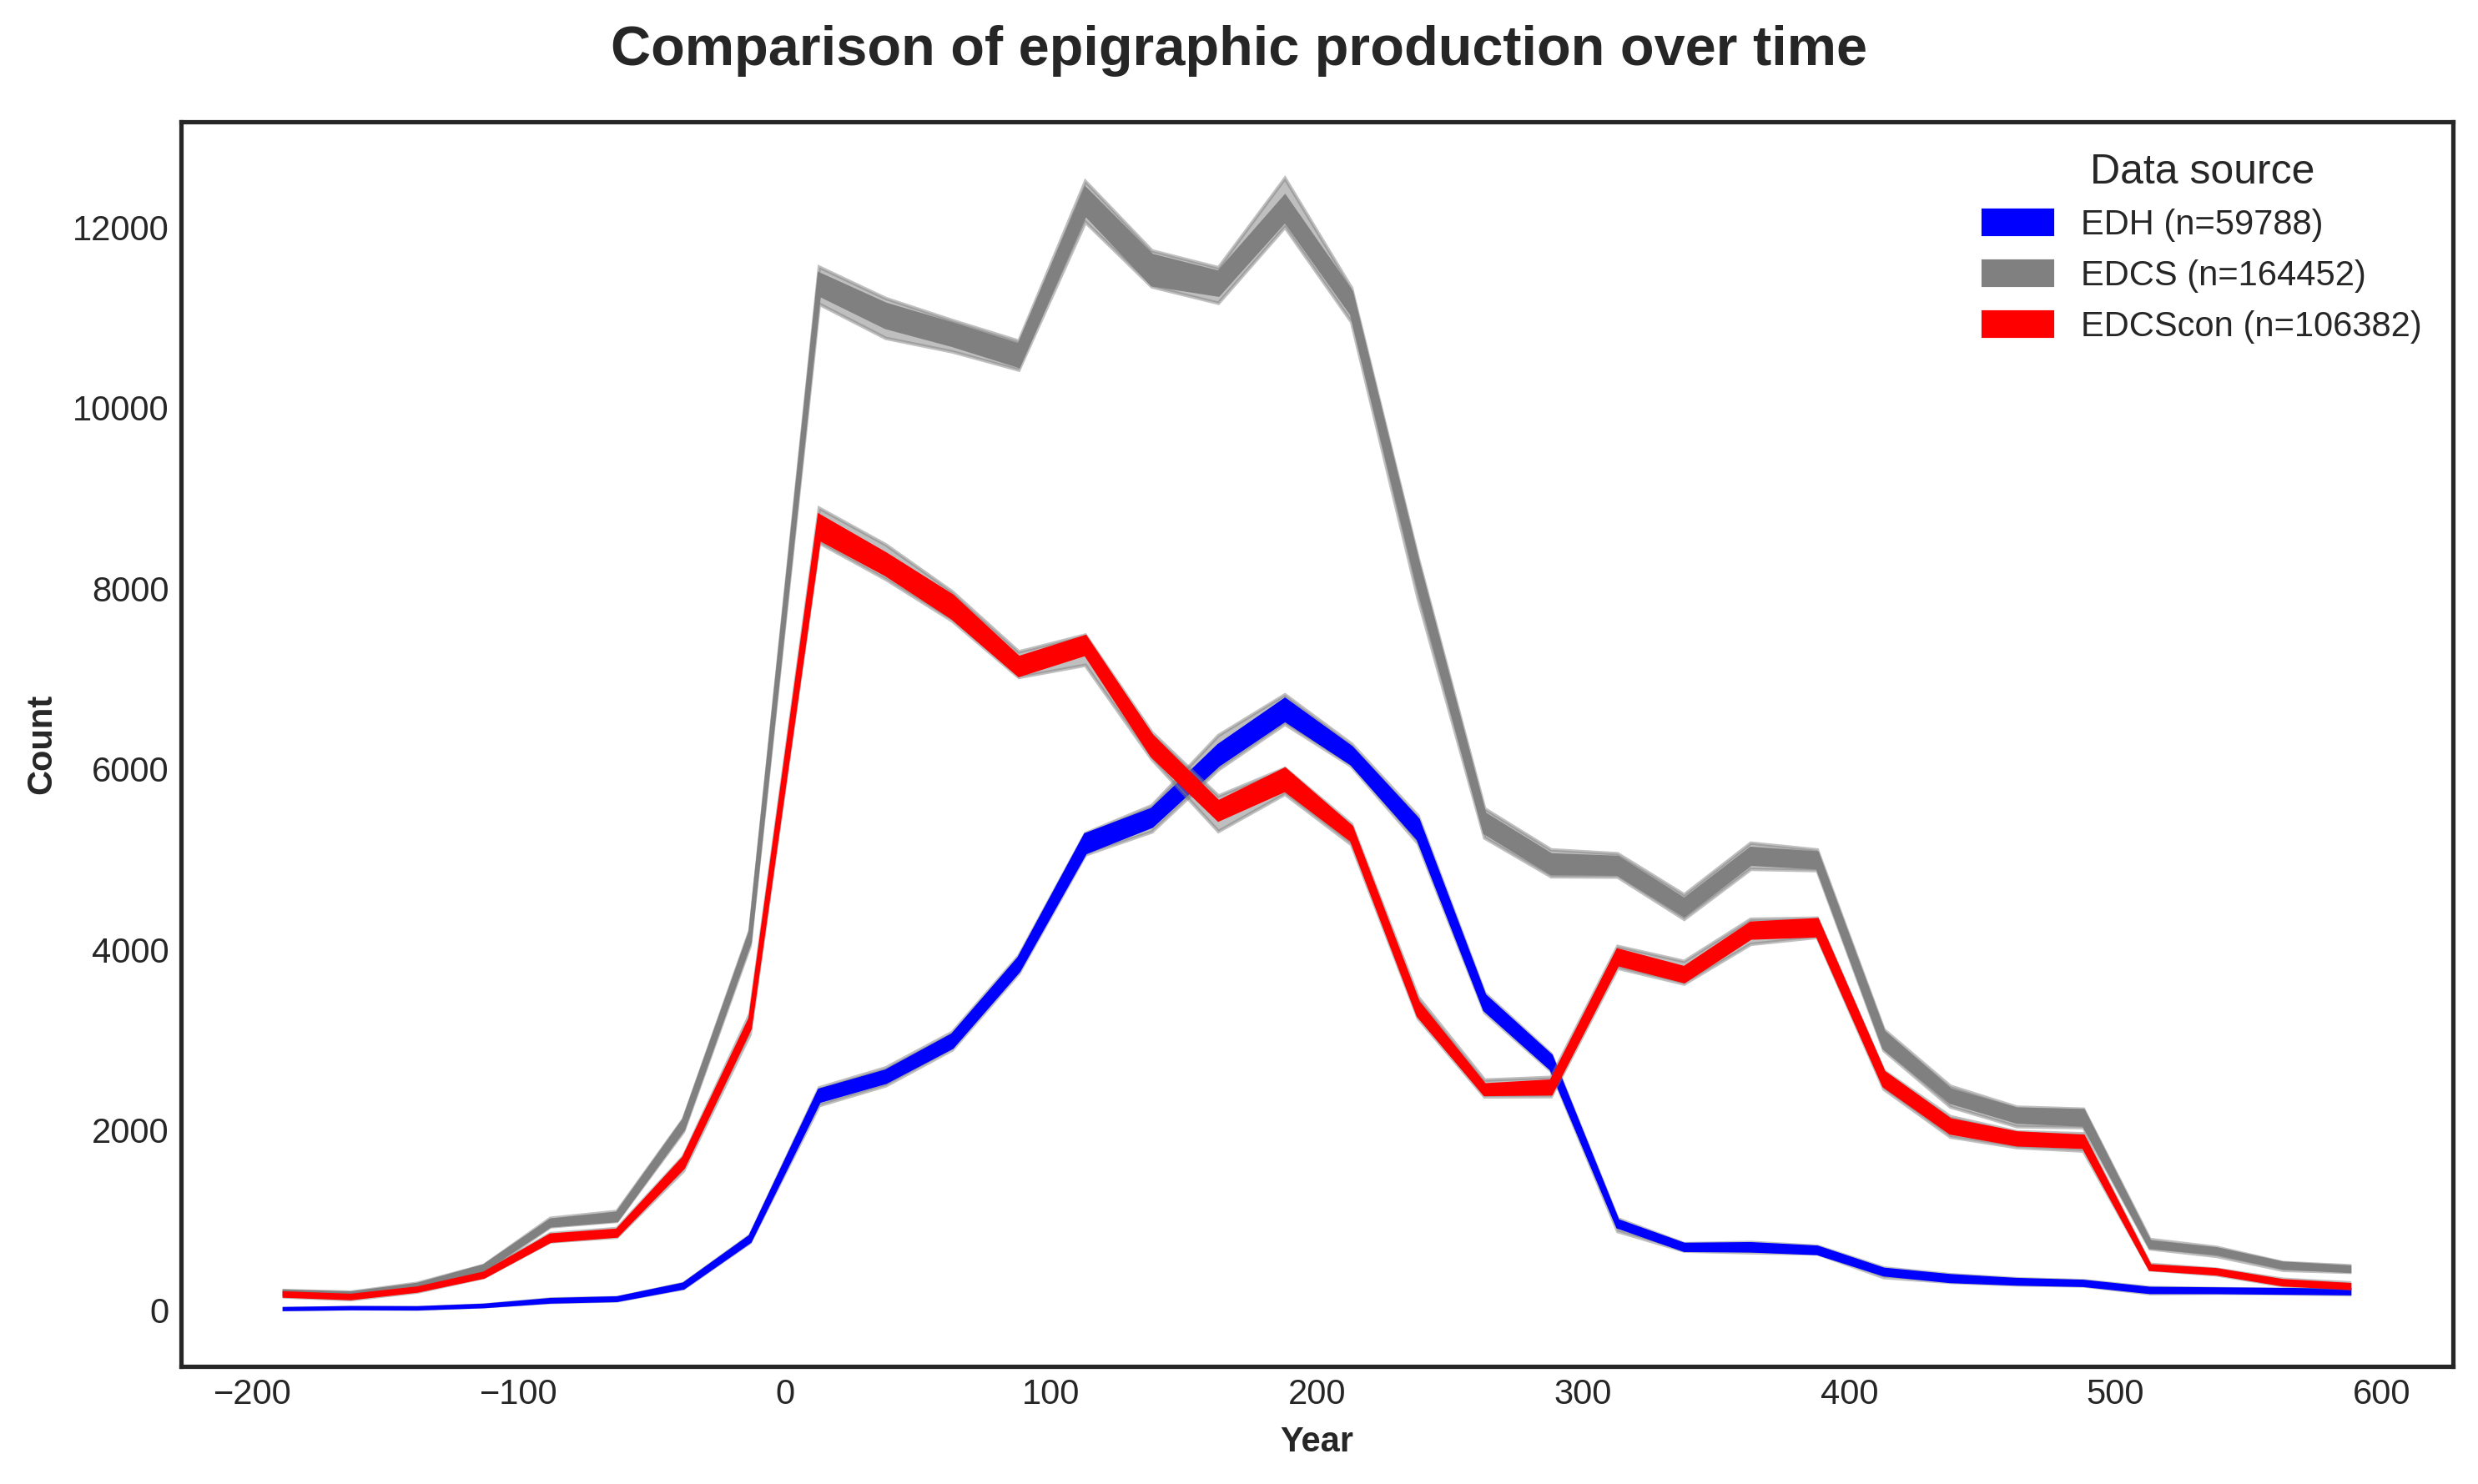

In [11]:
%%time
# Figure 1
# plot all three datasets into one plot comparing the epigraphic production in time

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

tempun.plot_timeblocks_data(
    EDH_complete_simulations, ax=ax, color="blue", label=f"EDH (n={len(EDH_dated)})")
tempun.plot_timeblocks_data(
    EDCS_complete_simulations, ax=ax, color="grey", label=f"EDCS (n={len(EDCS_dated)})")
tempun.plot_timeblocks_data(
    EDCScon_complete_simulations, ax=ax, color="red", label=f"EDCScon (n={len(EDCScon_dated)})")

ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
#ax.set_title("Total epigraphic production over time (EDCS and EDH compared)")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

#plt.axvline(x=212, linewidth=0.5, color = 'orange', linestyle='dashed')

fig.suptitle(f'Comparison of epigraphic production over time', fontsize=16,fontweight="bold")
plt.savefig('Epi_production_time.png')

Fig. 1: Comparison of the epigraphic production from 200 BC to 600 AD. The plot represents the results of 1000 iterations of Monte Carlo simulations per dataset, grouped by 25-year-long time blocks. The blue line represents the dated inscriptions in the EDH dataset (n=59,788), the grey line represents the full EDCS dataset (n=164,452), and the red line EDCS without the duplicate records from EDH (EDCScon, n=106,382).

The dated inscriptions in the EDH dataset (n=59,788) styled in blue show a steady growth of epigraphic production from the beginning of the Roman Imperial Period (27 BC) up to the AD 200, with the maximum produced inscriptions around 6,000 per 25 years. The maximum of production in AD 200 is followed by a century of steadily declining production of inscriptions. From AD 300 the numbers of preserved inscriptions in EDH maintained a relatively stable, yet slowly declining trend until AD 600 with only a small number of produced inscriptions.

The dated inscriptions in the complete EDCS dataset (n=164,452) in grey colour slowly rise already in the second century BC, followed by a steep increase in the number of produced inscriptions around the beginning of the Roman Imperial Period (27 BC), producing on average between 10,000 and 12,000 inscriptions per 25 years. The trend of high production remained relatively stable until AD 212, when a sharp decline reduced the production to 50% in the second half of the third century AD. During the fourth century AD, the epigraphic production fluctuated between 5,000-6,000 inscriptions per 25 years, followed by a drop to approximately 2,000 inscriptions per 25 years in the following century. Another drop in production came around AD 500, after which the production slowly faded away.

However, when we look at the trends in EDCScon, the dataset without the duplicate EDH records, represented by the red colour, we see a different trend than in EDCS or EDH. The total levels of production through time are lower in EDCScon dataset than in EDCS, as records shared with EDH were removed. This deduplication made it one third smaller and removed the peak of the Antonine era that dominated the EDH.  All in all, epigraphic activity in all three datasets starts in the first century BC, but while EDH shows slow gradual increase through the end of the second century AD, EDCScon here follows the EDCS take off and reaches a maximum point nearly instantly. This first and highest peak of epigraphic production under Augustus (27 BC - 14 AD) is followed by gradual but inexorable decline until the second half of the third century AD. After a brief plateau, the production of inscriptions in EDCScon recovers and starts rising again during the fourth century AD. This new growth in EDCScon, while robust and century-long, nonetheless, never reaches the levels of production from the first and second centuries AD.

The diachronic trends of growth and decline clearly vary between the datasets, partially due to the selection of contents. The production of inscriptions in the Augustan era dominates the EDCS dataset, while the Antonine peak is a global maximum in the EDH. The decline of the epigraphic production in the third century AD, often connected with the socio-economic crisis of the Roman Empire, is observable in both datasets, but while it has a permanent effect on EDH, EDCS and EDCScon datasets show recovery after AD 300.

While long-term trends across the datasets rise and fall differently through time and differ in magnitude, many of the spikes along these curves are shared and converge around the same dates. Spikes in epigraphic production across the Roman West have been observed in the Augustan era (14 BC - AD 27), the Antonine era (AD 97 - AD 192) and the Severan era (AD 193 - AD 235) (Nawotka 2021, 230). These synchronized spikes, rather than representing actual empire-wide phenomena such as sudden massive issue of new inscriptions, are likely an artefact of editorial decisions. The authors of the *editio princeps* would often assign the inscriptions start and end dates coterminous with the boundaries of historical periods such as the `Augustan era` (14 BC - AD 27), or known historical events, such as issue of *Constitutio Antoniniana* in AD 212. Established cultural periods were used as meaningful anchors for relative dates. 

All in all, when plotting EDH and EDCS side-by-side in Figure 1 we can see that each dataset yields a different image of the epigraphic production, although they cover the same historical material from the same time periods. In order to better understand the reason behind such differences we need to explore more closely the contents and the geographic distribution of inscriptions within both sources.

### Aspects of  epigraphic production 
Previous observations of changing trends in epigraphic production were mostly made on the basis of private inscriptions, specifically funerary texts (Macmullen 1982; Meyer 1990; Woolf 1996). It is unclear whether the observed trends apply to other types of inscriptions (non-private, non-funerary), and so we shall review the diachronic development of inscriptions by their type. 

The distinction between what constitutes private and public epigraphy can be very subjective and its exact definition may differ depending on the perspective of the issuer vs. intended audience. While most inscriptions were intended for public consumption, we differentiate private and public in reference to the commissioning entity behind an inscription. Based on the ongoing discussion within the [Epigraphy.info Vocabulary Working Group](https://epigraphy.info/vocabularies_wg/), we have drawn provisional dividing lines as follows: in the broadest sense, private inscriptions are texts, commissioned and executed on behalf of individuals or social groups not acting in the capacity of an institution or in a religious role. Amongst others, the group of private inscriptions can encompass funerary inscriptions issued in the case of someone’s death, votive inscriptions celebrating or thanking a deity, ownership inscriptions identifying the owner of the inscribed object, inscriptions connected with manufacturing process, identifying the maker or the process itself. The public inscriptions, conversely, are inscriptions issued by a person or group of people acting within an institutional or legal role, potentially having an impact on the public sphere. In this category we can typically find regulatory documents, such as laws and decrees, inscriptions informing of various building activities, milestones, inscriptions delimiting the boundaries, and certifications of social status, such as military diploma or manumissions. In some instances, the private and public sphere cannot be entirely separated, as the same type was used for monuments published on behalf of a public authority as well as a private individual or social group.

For the purpose of temporal comparison of epigraphic types, we use the subset of dated inscriptions from both datasets: EDH (n=59,788) and EDCScon (n=106,382). Both datasets contain the attribute `inscription_type`, however its content is mutually incompatible. EDH dataset operates with 22 unique categories for type of an inscription, if we count only labels stripped of any markers of uncertainty, such as question-mark, associated with the categorisation of an inscription. The EDSCcon dataset contains 16 unique categories of inscription type, with an average of 1.08 types per inscription and a maximum of five labels (`inscription genus/titulorum distributio`) per inscription. Moreover, the typological categories of EDH and EDCS do not always correspond to one another, with variants of the former overlapping with several of the categories in the second source. For instance, the category of `owner/artist inscription` in EDH does not exist in EDSC, but can be conceptually divided into two categories `tituli possessionis` and `tituli fabricationis`.

In [43]:
%%time
# Inscriptions by their type over time, EDH

simulations_by_type_len_EDH = []

for ins_type in EDH["type_of_inscription_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"] == ins_type]
        simulations_by_type_len_EDH.append((ins_type, len(subset_df)))
simulations_by_type_len_EDH = sorted(
    simulations_by_type_len_EDH, key=lambda x: x[1], reverse=True)
simulations_by_type_len_EDH

simulations_by_type_EDH = []

for ins_type_tup in simulations_by_type_len_EDH[:8]:
    subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"]
                          == ins_type_tup[0]]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_EDH.append([ins_type_tup[0], ins_type_N, simulations])
simulations_by_type_EDH = sorted(
    simulations_by_type_EDH, key=lambda x: x[1], reverse=True)

date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len_EDH[:10]:
    subset_df = EDH_dated[EDH_dated["type_of_inscription_clean"]
                          == ins_type_tup[0]]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 6.23 s, sys: 239 ms, total: 6.47 s
Wall time: 6.46 s


In [44]:
simulations_by_type_len_EDH

[('epitaph', 25516),
 ('votive inscription', 13018),
 ('owner/artist inscription', 4224),
 ('honorific inscription', 3576),
 ('building/dedicatory inscription', 3107),
 ('mile-/leaguestone', 1630),
 ('identification inscription', 1377),
 ('acclamation', 470),
 ('military diploma', 410),
 ('list', 328),
 ('defixio', 297),
 ('label', 232),
 ('boundary inscription', 203),
 ('public legal inscription', 182),
 ('elogium', 138),
 ('letter', 121),
 ('seat inscription', 66),
 ('prayer', 50),
 ('private legal inscription', 43),
 ('assignation inscription', 16),
 ('calendar', 11),
 ('adnuntiatio', 3)]

In [45]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


EDCScon_dated["inscr_type_list_flat"] = EDCScon_dated["inscr_type"].apply(
    clean_inscr_type)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [46]:
inscr_types_flatlist_EDCScon = [
    el for ellist in EDCScon_dated["inscr_type_list_flat"].tolist() for el in ellist]
simulations_by_type_len_EDCScon = list(
    nltk.FreqDist(inscr_types_flatlist_EDCScon).most_common())
simulations_by_type_len_EDCScon

[('tituli sepulcrales', 59490),
 ('inscriptiones christianae', 24274),
 ('tituli sacri', 7184),
 ('tituli fabricationis', 7032),
 ('tituli operum', 4545),
 ('tituli possessionis', 4188),
 ('tituli honorarii', 2928),
 ('miliaria', 2171),
 ('carmina', 1278),
 ('diplomata militaria', 559),
 ('leges', 399),
 ('termini', 350),
 ('signacula', 265),
 ('defixiones', 151),
 ('reges', 55),
 ('senatus consulta', 13)]

In [47]:
%%time
# Inscriptions by type over time

simulations_by_type_EDCScon = []

for ins_type_tup in simulations_by_type_len_EDCScon[:8]:
    subset_df = EDCScon_dated[EDCScon_dated["inscr_type_list_flat"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_EDCScon.append(
        [ins_type_tup[0], ins_type_N, simulations])

date_vars_by_instypes = []
for ins_type_tup in simulations_by_type_len_EDCScon[:10]:
    subset_df = EDCScon_dated[EDCScon_dated["inscr_type_list_flat"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 13.9 s, sys: 186 ms, total: 14.1 s
Wall time: 14 s


In [48]:
# custom pallette for EDCS inscription types, to distinguish the differences between classification labels
tab_colors_list_edcs = ['tab:blue', 
                        'goldenrod', 
                        'tab:orange', 
                        'teal',
                        'maroon',
                        'tab:green',
                        'tab:red',
                        'tab:brown',
                        'lightcoral',
                        'tab:olive']


CPU times: user 1.67 s, sys: 261 ms, total: 1.93 s
Wall time: 1.67 s


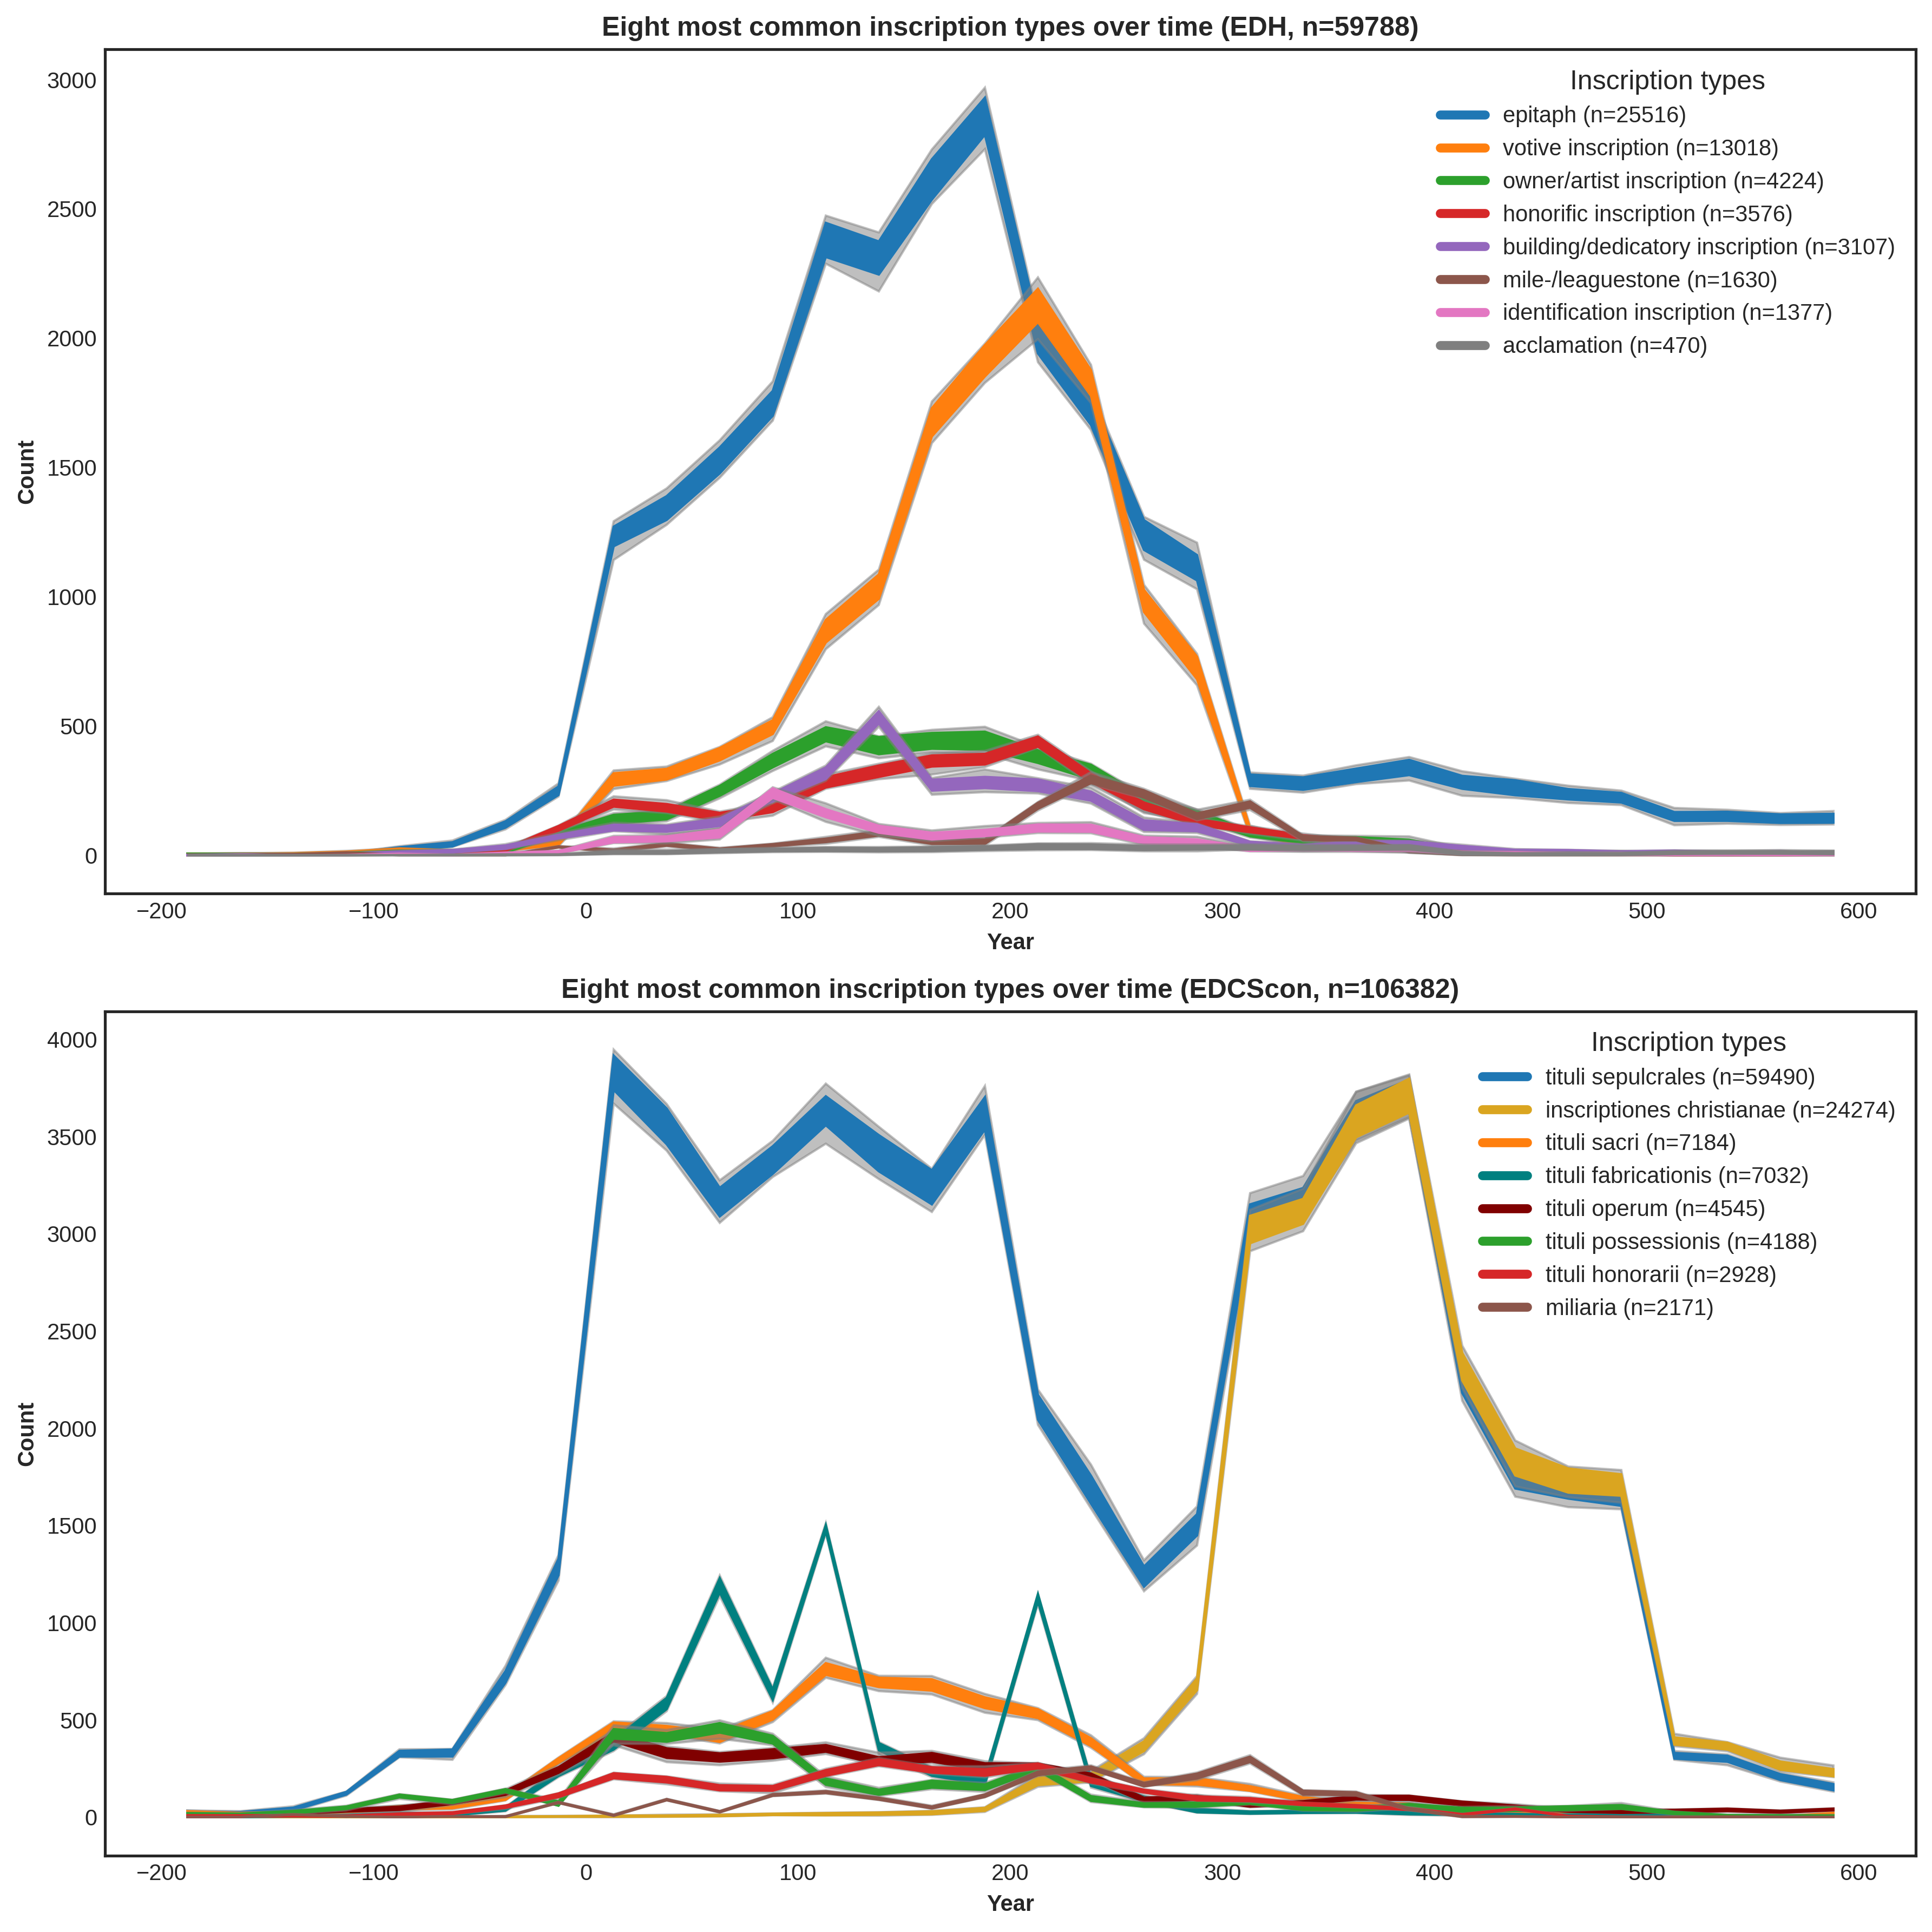

In [49]:
%%time
# Figure 2
# Plot combining EDH and EDCScon
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 12), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_EDH, tab_colors_list[:len(simulations_by_type_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Year", weight="bold")
ax1.set_ylabel("Count", weight="bold")
ax1.set_title(f"Eight most common inscription types over time (EDH, n={len(EDH_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_EDH)]]

legend_labels_EDH = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDH]

ax1.legend(markers, legend_labels_EDH, numpoints=1,  
           title="Inscription types", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_type_EDCScon, tab_colors_list_edcs):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Year", weight="bold")
ax2.set_ylabel("Count", weight="bold")
ax2.set_title(f"Eight most common inscription types over time (EDCScon, n={len(EDCScon_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list_edcs]
legend_labels_EDCScon = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_EDCScon]

ax2.legend(markers, legend_labels_EDCScon, numpoints=1,
           title="Inscription types", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig('Typologies_comparison_time.png')

Fig. 2: The eight most common types of inscription in the EDH (n=59,788) and EDCScon (n=106,382) dataset between 200 BC and AD 600. EDH provides one type per inscription, whereas EDSC can have multiple labels per one inscription. To the groups of private texts belong: epitaphs in EDH/ tituli sepulcrales in EDCS, votive inscriptions in EDH / tituli sacri in EDCS), owner/artist inscriptions in EDH / tituli possessionis and tituli fabricationis in EDCS, and tituli christianae in EDCS. Public inscriptions: building/dedicatory inscriptions in EDH / tituli operum in EDCS, mile-leaguestone in EDH / miliaria in EDCS, acclamation in EDCS. Inscriptions both private and public, depending on context: honorific inscriptions in EDH / tituli honoraria in EDCS, identification inscriptions in EDH.

Figure 2 shows the vast majority of inscriptions in EDH and EDCScon were published by the private sector, on behalf of individuals or private groups, and not on behalf of a public authority. The funerary inscriptions represent the most numerous group of private inscriptions in both datasets (epitaph in EDH, ‘tituli sepulcrales’ in EDCScon) , both steeply rising in number, not surprisingly, around the time of Augustus (Bodel 2001, 7). The second most numerous group consists of  the votive inscriptions in EDH and Christian inscriptions in EDCScon (`inscriptiones christianae`) . The votive inscriptions (`tituli sacri`) in EDCScon represent the third most numerous group, with the most inscriptions dated to the second century AD. The trend in the production of votive inscriptions in EDH seems delayed by ca. 100 years when compared to the funerary inscriptions. Funerary and votive inscriptions in EDH and EDCScon, however, start decreasing around the same time, after AD 200. Production continues to decline during the entire third century AD, making it a society-wide phenomenon observable in both data sources.

In order to test MacMullen’s or Meyer’s hypothesis of inscriptions being co-opted in the competition for social status, further exploration of how social prestige is expressed or generated through the inscriptions before and after AD 212 is needed. While a combination of the temporal modeling with text mining approaches should make this avenue of analysis possible, the combination of close and distant reading is out of scope of the present paper.

An alternative explanation of the decline in private inscriptions point to the role of infectious diseases and decimation of the population of the Roman Empire. According to some, during the outbreaks of the so-called Antonine Plague in AD 165 and AD 189 around 10 % (ca. 10 mil.) of the entire population of the Roman Empire died (Littman and Littman, 1973, 252; Verhagen 2019; Harper 2016, 806). The increased mortality likely influenced the growing number of  funerary inscriptions in short-term, i.e. at the time of plague, while in long-term the increase would be likely followed by a period of limited production caused by the reduction within the epigraphically active population. However, a detailed study linking the role of infectious diseases on publication of private inscriptions is yet to be published.

Inscriptions published on behalf of political authorities, such as honorific inscriptions, building inscriptions or milestones are represented in both sources in relatively low quantities and with delayed onset, when compared to the group of inscriptions published by private sphere. The increase of building inscriptions in EDH before the middle of the second century AD may correspond with the provincial building programme of emperor Hadrian (AD 117-138; Wilson 2012, 163). In EDSC the number of inscriptions related to building activities, `tituli operum`, grew already during the late Republic and the first century AD to around 300 inscriptions per 25 years, possibly related to the Imperial building program in Rome (Bodel 2001, 7). However, the decrease in the number of building inscriptions after AD 200 is slow, yet continuous throughout the third century AD and does show any disruption of the trend, as is noticeable in the private inscriptions.

Milestones ‘miliaria’ are a category of public inscriptions, erected along roads to relate the distance to the administrative centre (`caput viae`), and to provide information on who and when financed the road (re)construction. The trends of milestone production differ from the private inscriptions (in scale kind) as well as between EDH and EDCScon datasets. Roads were already built during the Roman Republic, but milestones survived in comparatively low numbers. With the beginning of the Imperial period we see an increased production (Bodel 2001, 7), varying between 50 (EDH) and 120 (EDCS) surviving milestones per 25 years. The growth in the number of milestones is evident in both sources during the third century AD and the beginning of the fourth century AD, when up to 300 inscriptions in 25 years were produced in both datasets. The period of increased production of milestones coincides with the extensive building of the road network in the provinces in the second century AD (Laurence 1999, 52; Kolb 2019, 8-10). The milestones from the third and fourth centuries point to maintenance work and reconstruction of the road system, suggesting the provincial institutions maintaining the road network were still active and commissioning inscriptions, although the public epigraphic production in provinces was reduced to a minimum.

Honorific inscriptions, straddling the divide between private and public texts, show a similar trend in production as private inscriptions, observed already by Andrew Wilson (2012). There is an increase in the first half of the first century AD, followed by steady production of 200-300 honorific inscriptions per 25-year-long time blocks. The peak of production is dated between AD 200-225, followed by a decrease in production. Although Meyer (1990) was using funerary rather than honorific inscriptions to illustrate the decline of epigraphic habit, a similar trend in the honorific inscriptions after AD 200 suggests conceptual closeness of both categories.

Deviating from the public / private distinction are the `Christian inscriptions` that, however, appear only in EDCS. The label `inscriptiones christianae` describes a religious context in which the inscription was created rather than its societal function and works as an additional category to any traditional type of inscription, such as funerary, votive or ownership inscription. The vast majority (94.4 %) of dated Christian inscriptions in EDCS are also labeled as funerary (`tituli sepulcrales`), therefore belonging primarily to a private funerary context. As to their temporal trend, the Christian funerary inscriptions deviate from the trends of non-Christian funerary epigraphic production, as they only start to appear after AD 200, when the rest of funerary production declines. On the contrary, the production of Christian funerary inscriptions increases around AD 300 on a massive scale (3000-3500 inscriptions per 25 years). At the same time, the production of all other types of inscriptions is almost non-existent. To position the numbers in a discipline specific context, it is worth noting, that periods after AD 300 may be underrepresented in our sources as Late Antique inscriptions are often collected by specialised projects and databases and they are missing in the systematic collection in the large digital corpora (Trout 2009, 171; Roueché and Sotinel 2017, 503-507).

The patterns of private and public epigraphic production in EDH and EDCS are rather different. While the private inscriptions, represented mostly by funerary and votive texts, follow the same pattern as observed by MacMullen and Meyer, the public inscriptions are linked to the activities of political authorities, such as various building programs and maintenance of the road network. Thus, the *epigraphic habit* with its rise and fall at the turn of the third century AD does apply to private production, while the public inscriptions exhibit a gently upward trend that follows the continually growing demand on the maintenance of the technical infrastructure in an expanding Empire.

While Figures 1 and 2 allow us to gauge the large picture of the epigraphic categories through time, we need to remember that the dataset has a continental scale and that regional variation is flattened and collated here. Let us bring in the spatial dimension and attempt to review the diachronic patterns in space and by province. 

### The extent of epigraphic production in historic eras

In order to better visualise the spatial extent of the epigraphic production in both datasets through time, we create a series of eight time maps covering the epigraphic production in the given historical period. Plotting inscriptions by source and historical period makes it possible to both assess the distribution of inscriptions across the Roman Empire and evaluate potential blindspots of the datasets. Such an approach would benefit from the addition of other large-scale longitudinal and geospatial datasets from the Ancient Mediterranean, such as production of coins, distribution of pottery assemblages, building of road network, settlements patterns and many others (Bowman and Wilson 2009).

For the purpose of spatiotemporal comparison of EDCS and EDH we use the consolidated EDCScon dataset without duplicate records from EDH. We use only inscriptions that are both dated and their spatial coordinates are located within the borders of the Roman Empire within its largest extent in AD 117 (EDH n=55,431, EDCScon n=90,281 records). For definition of the maximum spatial extent of the Roman Empire in AD 117 we are using the `pleiades-regions-magis-pelagios.geojson`, based on the Barrington Atlas of Greek and Roman World, available through [Pelagios on GitHub](https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson). The subplots in Figure 5 are based on one time series simulation of the whole EDH and EDCScon datasets (see above). That means that each inscription is randomly assigned to one singular year. In theory, an inscription dated to the second century AD might become part of three subplots, but in practice, it is included only in one of them. Every time we again generate the random dates, the maps slightly change as some inscriptions may shift from one historical period to another; but the general pattern remains the same.

In [12]:
# periods definitions

periods = {  # to avoid overlaps, startdates are postponed by one year, when needed
    "Late Roman Republic": {"startdate": -200, "enddate": -26, "duration": 175},
    "Julio-Claudian dyn.": {"startdate": -27, "enddate": 68, "duration": 95},
    "Flavian dyn.": {"startdate": 69, "enddate": 96,"duration": 28},
    "Nerva-Antonine dyn.": {"startdate": 97, "enddate": 192, "duration": 96},
    "Severan dyn.": {"startdate": 193, "enddate": 235, "duration": 43},
    "Military emperors": {"startdate": 236, "enddate": 284,"duration": 49},
    "Tetrarchy-Constantine I": {"startdate": 285, "enddate": 337,"duration": 53},
    "Late Roman Empire": {"startdate": 338, "enddate": 600,"duration": 263}
}
timeblocks_periods = [(periods[period]["startdate"],
                       periods[period]["enddate"],
                       periods[period]["duration"]) for period in periods]
timeblocks_periods

[(-200, -26, 175),
 (-27, 68, 95),
 (69, 96, 28),
 (97, 192, 96),
 (193, 235, 43),
 (236, 284, 49),
 (285, 337, 53),
 (338, 600, 263)]

In [13]:
def date_to_str(date):
    if date < 0:
        date = str(abs(date)) + " BC"
    else:
        date = "AD " + str(date)
    return date


periods_labels = []
for period in periods.keys():
    start = date_to_str(periods[period]["startdate"])
    end = date_to_str(periods[period]["enddate"])
    periods_labels.append(period + "\n({0}-{1})".format(start, end))
periods_labels

['Late Roman Republic\n(200 BC-26 BC)',
 'Julio-Claudian dyn.\n(27 BC-AD 68)',
 'Flavian dyn.\n(AD 69-AD 96)',
 'Nerva-Antonine dyn.\n(AD 97-AD 192)',
 'Severan dyn.\n(AD 193-AD 235)',
 'Military emperors\n(AD 236-AD 284)',
 'Tetrarchy-Constantine I\n(AD 285-AD 337)',
 'Late Roman Empire\n(AD 338-AD 600)']

In [14]:
# loading shapefile from Pleaides for the largest extent of the Roman Empire, AD 117
# source: https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson
pleiades_regions = gpd.read_file('../data/pleiades_regions.geojson', driver='GeoJSON')
RE_merged = pleiades_regions.unary_union

In [15]:
def get_date_var(randoms):
    try:
        return randoms[0]
    except:
        return None

# selecting one random date out of the 1000 version
EDH_dated["date_var_1"] = EDH_dated["random_dates"].apply(get_date_var)

In [16]:
# modifying coordinates in EDH to fit the script
EDH_dated[['Longitude', 'Latitude']] = pd.DataFrame(EDH_dated.coordinates. tolist(), index=EDH_dated.index)

In [69]:
%%time
EDH_dated_df_by_periods = []

for period in timeblocks_periods:
    EDH_dated_sample = EDH_dated[EDH_dated["date_var_1"].between(
        period[0], period[1])]
    # tranforming EDH as geodataframe
    EDH_dated_sample = EDH_dated_sample[EDH_dated_sample["Latitude"].notnull()]
    EDH_dated_sample = gpd.GeoDataFrame(EDH_dated_sample, geometry=gpd.points_from_xy(EDH_dated_sample["Longitude"], EDH_dated_sample["Latitude"]))
    # selecting only those dated and within borders of the Empire (the largest extent in AD 117)
    EDH_dated_sample = EDH_dated_sample[EDH_dated_sample.within(RE_merged)]
    EDH_dated_df_by_periods.append(EDH_dated_sample)

CPU times: user 6min 1s, sys: 2.49 s, total: 6min 4s
Wall time: 6min 4s


In [149]:
#saving locally for future use
for gdf, n in zip(EDH_dated_df_by_periods, range(len(EDH_dated_df_by_periods))):
    with open("../output/EDH_dated_period_RE_{0}.geojson".format(str(n)), "w") as file: 
        json.dump(sddk.gdf_to_geojson(gdf), file)

In [17]:
%%time
# reading the local geojson back:
EDH_dated_df_by_periods = []
for n in range(8):
    gdf = gpd.read_file("../output/EDH_dated_period_RE_{0}.geojson".format(str(n)), driver="GeoJSON")
    EDH_dated_df_by_periods.append(gdf)

CPU times: user 24.2 s, sys: 1.03 s, total: 25.2 s
Wall time: 26.4 s


In [19]:
# selecting one random date out of the 1000 version
EDCScon_dated["date_var_1"] = EDCScon_dated["random_dates"].apply(get_date_var)

In [73]:
%%time
EDCScon_dated_df_by_periods = []

for period in timeblocks_periods:
    EDCScon_dated_sample = EDCScon_dated[EDCScon_dated["date_var_1"].between(
        period[0], period[1])]
    # tranforming EDCSconcon as geodataframe
    EDCScon_dated_sample = EDCScon_dated_sample[EDCScon_dated_sample["Latitude"].notnull()]
    EDCScon_dated_sample = gpd.GeoDataFrame(EDCScon_dated_sample, geometry=gpd.points_from_xy(EDCScon_dated_sample["Longitude"], EDCScon_dated_sample["Latitude"]))
    # selecting only those dated and within borders of the Empire (the largest extent in AD 117)
    EDCScon_dated_sample = EDCScon_dated_sample[EDCScon_dated_sample.within(RE_merged)]
    EDCScon_dated_df_by_periods.append(EDCScon_dated_sample)

CPU times: user 10min 44s, sys: 5.8 s, total: 10min 49s
Wall time: 10min 49s


In [150]:
#saving locally for future use
for gdf, n in zip(EDCScon_dated_df_by_periods, range(len(EDCScon_dated_df_by_periods))):
    with open("../output/EDCScon_dated_period_RE_{0}.geojson".format(str(n)), "w") as file: 
        json.dump(sddk.gdf_to_geojson(gdf), file)

In [20]:
%%time
# reading local geojson back:
EDCScon_dated_df_by_periods = []
for n in range(8):
    gdf = gpd.read_file("../output/EDCScon_dated_period_RE_{0}.geojson".format(str(n)), driver="GeoJSON")
    EDCScon_dated_df_by_periods.append(gdf)

CPU times: user 19.6 s, sys: 951 ms, total: 20.5 s
Wall time: 23.1 s


CPU times: user 22.4 s, sys: 3.18 s, total: 25.6 s
Wall time: 24.3 s


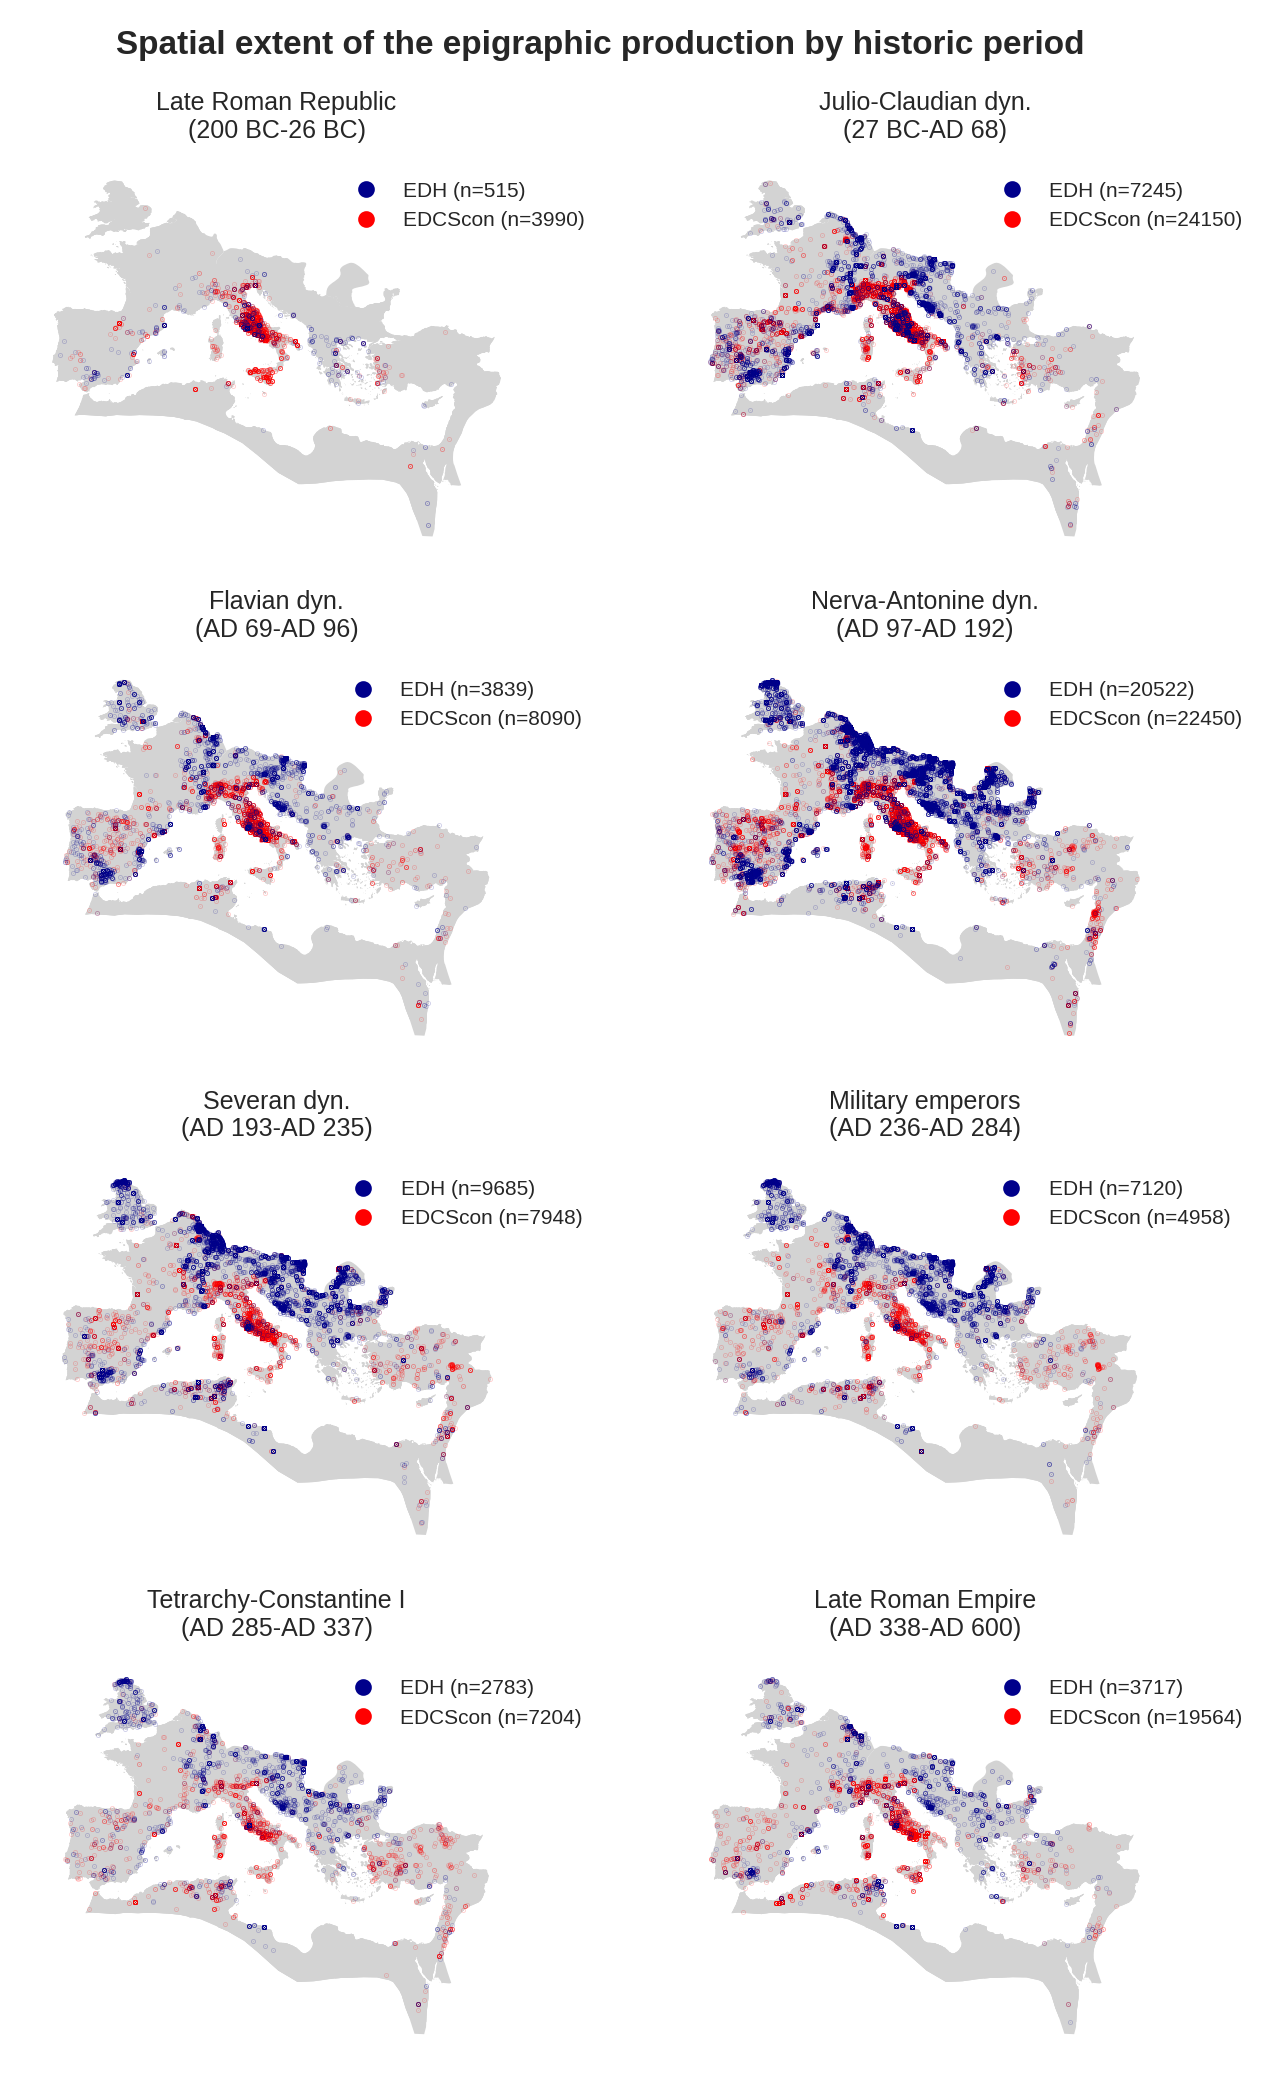

In [8]:
%%time
# Figure 3
# plot all EDH and EDCScon inscriptions with location in 8 plots grouped by period
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8


fig, axs  = plt.subplots(4, 2, figsize=(7, 7), tight_layout=True)

contexts_pct = {}
    
for df_edcs, df_edh, ax, period in zip(EDCScon_dated_df_by_periods, EDH_dated_df_by_periods, axs.ravel(), periods_labels):
    pleiades_regions.plot(ax=ax, color="lightgray")
    df_edcs.plot(markersize=0.04, color="red", ax=ax, alpha=0.2, label=len(df_edcs))
    df_edh.plot(markersize=0.04, color="darkblue", ax=ax, alpha=0.2, label=len(df_edh))
    ax.set_title(period, fontsize=6)
    ax.set_axis_off()
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=".", linestyle="") for color in ["darkblue", "red"]]
    legend_labels = ["EDH (n={0})".format(str(len(df_edh))), 
                     "EDCScon (n={0})".format(str(len(df_edcs)))]
    
    ax.legend(markers, legend_labels, numpoints=1, bbox_to_anchor=(0.6, 1), loc='upper left', fontsize=5)
   
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

fig.suptitle(f'Spatial extent of the epigraphic production by historic period', fontsize=8, fontweight="bold")
plt.savefig('Epi_production_periods_EDCS_EDH.png')

Fig. 3: Comparison of the spatial extent of the epigraphic production in EDH and EDCScon grouped by historical periods. The subplots are results of one time series, treating each inscription as assigned to a singular year within its dating interval. The figure depicts only inscriptions located within the borders of the Roman Empire during its largest extent in AD 117 (EDH n=55,431, EDCScon n=90,281 records).

Although the historic periods have a different duration and thus longer periods will naturally contain more inscriptions, the division to historic periods better corresponds to the temporal interval assigned in the original corpora, i.e Augustan era (27 BC - AD 14) or Severan dynasty (AD 193 - AD 235). The main advantage of the time series approach is that we can transform inscriptions of uneven length of their temporal interval, and with uneven level of uncertainty of their dating, to the same format, and then contrast the extent of the epigraphic production within the historical periods traditionally used by historians, using the data in homogenous format.

Some of the main differences between the two data-sources observed in the previous sections are even more visible in Figure 3. We can see clear spatial focus of EDCS on Rome and Italic provinces throughout all historical periods, while EDH spatial coverage is more centered around the northern provinces, such as Britannia, both Germanias, Noricum, both Pannonias, and Hispania in the south. The areas of Northern Africa, Gaul and Greece, where the *epigraphic habit* of the Severan period has been traditionally observed, do not yield as many inscriptions in our sources.

When contrasted in time, the first observed period of epigraphic activity during the Late Roman Republic (200 BC - 27 BC) shows low levels of activity mostly in Rome and Italic provinces, Hispania, Greece and Asia Minor. The majority of these places have a tradition of publication of inscriptions in Greek in the previous periods and some of the trends may be partially documented also in EDH and EDCS as both contain a small number of Greek inscriptions. The extensive development of provincial epigraphic production around the Limes Romanus is noticeable during the second and early third century AD during the Nerva-Antonine period (AD 97 - AD 192) and Severan period (AD 193 - AD 235) and is predominantly fueled by the data from EDH.

Because of its uneven length, the historic periods may not be the most efficient way to visualise the quantity of epigraphic production. However, the traditional periodization still has its stable place in historical narratives and they provide a wider socio-cultural framework for any historic debate. The comparable format of the temporal data, created by the MCM temporal approach, enabled us to transform the epigraphic records with available spatial coordinates into a more dynamic series of maps, representing spatial trends in eight cumulative snapshots of the past. The main benefit of the spatial visualisation of epigraphic data divided into historic periods is clear communication of the spatial distinction between the two datasets and the level of their bias towards collecting inscriptions with focus on one area (EDCS), or along the border of the Empire (EDH). By slicing the epigraphic production in time and space, we have discovered a similar spatial bias is present throughout all the subplots, in total representing the 800-year-long time span, varying only in intensity of epigraphic production in a given period.

### Global vs Local?

In order to investigate spatial variation in the adoption of epigraphic habit, we display epigraphic activity by province, selecting the highest producing provinces for clarity. Can we see similar trends across all provinces or does location play a role?

Figure 4 shows the epigraphic production in eight provinces which together account for a majority of inscriptions across the EDH (n=59,788) and EDCScon (n=106,382) dataset. We can see the two distinct trends in epigraphic production that can be explained by different spatial focus of the two sources. 

In [18]:
%%time
# Inscriptions by province over time, EDH

simulations_by_prov_len_EDH = []

for ins_type in EDH["province_label_clean"].unique():
    if ins_type != "NULL":
        subset_df = EDH_dated[EDH_dated["province_label_clean"] == ins_type]
        simulations_by_prov_len_EDH.append((ins_type, len(subset_df)))
simulations_by_prov_len_EDH = sorted(
    simulations_by_prov_len_EDH, key=lambda x: x[1], reverse=True)
simulations_by_prov_len_EDH

simulations_by_prov_EDH = []

for ins_type_tup in simulations_by_prov_len_EDH[:10]:
    subset_df = EDH_dated[EDH_dated["province_label"] == ins_type_tup[0]]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_prov_EDH.append([ins_type_tup[0], ins_type_N, simulations])
simulations_by_prov_EDH = sorted(
    simulations_by_prov_EDH, key=lambda x: x[1], reverse=True)

CPU times: user 1.6 s, sys: 15.9 ms, total: 1.62 s
Wall time: 1.61 s


In [19]:
simulations_by_prov_len_EDH[:20]

[('Dalmatia', 7543),
 ('Germania superior', 6559),
 ('Britannia', 4402),
 ('Pannonia superior', 4182),
 ('Dacia', 3485),
 ('Pannonia inferior', 3109),
 ('Germania inferior', 3003),
 ('Noricum', 2726),
 ('Hispania citerior', 2668),
 ('Roma', 2556),
 ('Baetica', 2431),
 ('Moesia inferior', 1849),
 ('Numidia', 1599),
 ('Moesia superior', 1327),
 ('Africa Proconsularis', 1228),
 ('Macedonia', 1088),
 ('Raetia', 976),
 ('Belgica', 970),
 ('Latium et Campania (Regio I)', 820),
 ('Achaia', 636)]

In [20]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_province(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


In [21]:
EDCScon_dated["province"] = EDCScon_dated["province"].apply(clean_province)

In [22]:
provinces_flatlist_EDCScon = [
    el for ellist in EDCScon_dated["province"].tolist() for el in ellist]
simulations_by_prov_len_EDCScon = list(
    nltk.FreqDist(provinces_flatlist_EDCScon).most_common())
simulations_by_prov_len_EDCScon[:20]

[('Roma', 43392),
 ('Latium et Campania / Regio I', 15894),
 ('Venetia et Histria / Regio X', 5088),
 ('Hispania citerior', 3213),
 ('Samnium / Regio IV', 3167),
 ('Apulia et Calabria / Regio II', 2750),
 ('Etruria / Regio VII', 2724),
 ('Transpadana / Regio XI', 2519),
 ('Umbria / Regio VI', 2497),
 ('Germania superior', 2424),
 ('Africa proconsularis', 1997),
 ('Sicilia', 1913),
 ('Dacia', 1476),
 ('Numidia', 1406),
 ('Sardinia', 1068),
 ('Picenum / Regio V', 1035),
 ('Lusitania', 960),
 ('Liguria / Regio IX', 942),
 ('Aemilia / Regio VIII', 915),
 ('Belgica', 904)]

In [23]:
%%time
# Inscriptions by Province over time, EDCScon

simulations_by_prov_EDCScon = []

for ins_type_tup in simulations_by_prov_len_EDCScon[:10]:
    subset_df = EDCScon_dated[EDCScon_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_prov_EDCScon.append(
        [ins_type_tup[0], ins_type_N, simulations])

date_vars_by_instypes = []
for ins_type_tup in simulations_by_prov_len_EDCScon[:10]:
    subset_df = EDCScon_dated[EDCScon_dated["province"].apply(
        lambda x: ins_type_tup[0] in x)]
    date_vars = []
    for n in range(100):
        date_vars.append(
            [date_var[n] for date_var in subset_df["random_dates"] if date_var != None])
    date_vars_by_instypes.append(date_vars)

CPU times: user 4.81 s, sys: 45.8 ms, total: 4.86 s
Wall time: 4.85 s


In [34]:
# custom pallette for EDCS provinces, to distinguish the differences between labels
tab_colors_list_prov_edcs = [ 
                        'darkturquoise', 
                        'lightcoral', 
                        'lime', 
                        'blue',
                        'maroon',
                        'magenta',
                        'yellow',
                        'tomato',
                        'lavender',
                        'orange']

CPU times: user 1.59 s, sys: 268 ms, total: 1.85 s
Wall time: 1.6 s


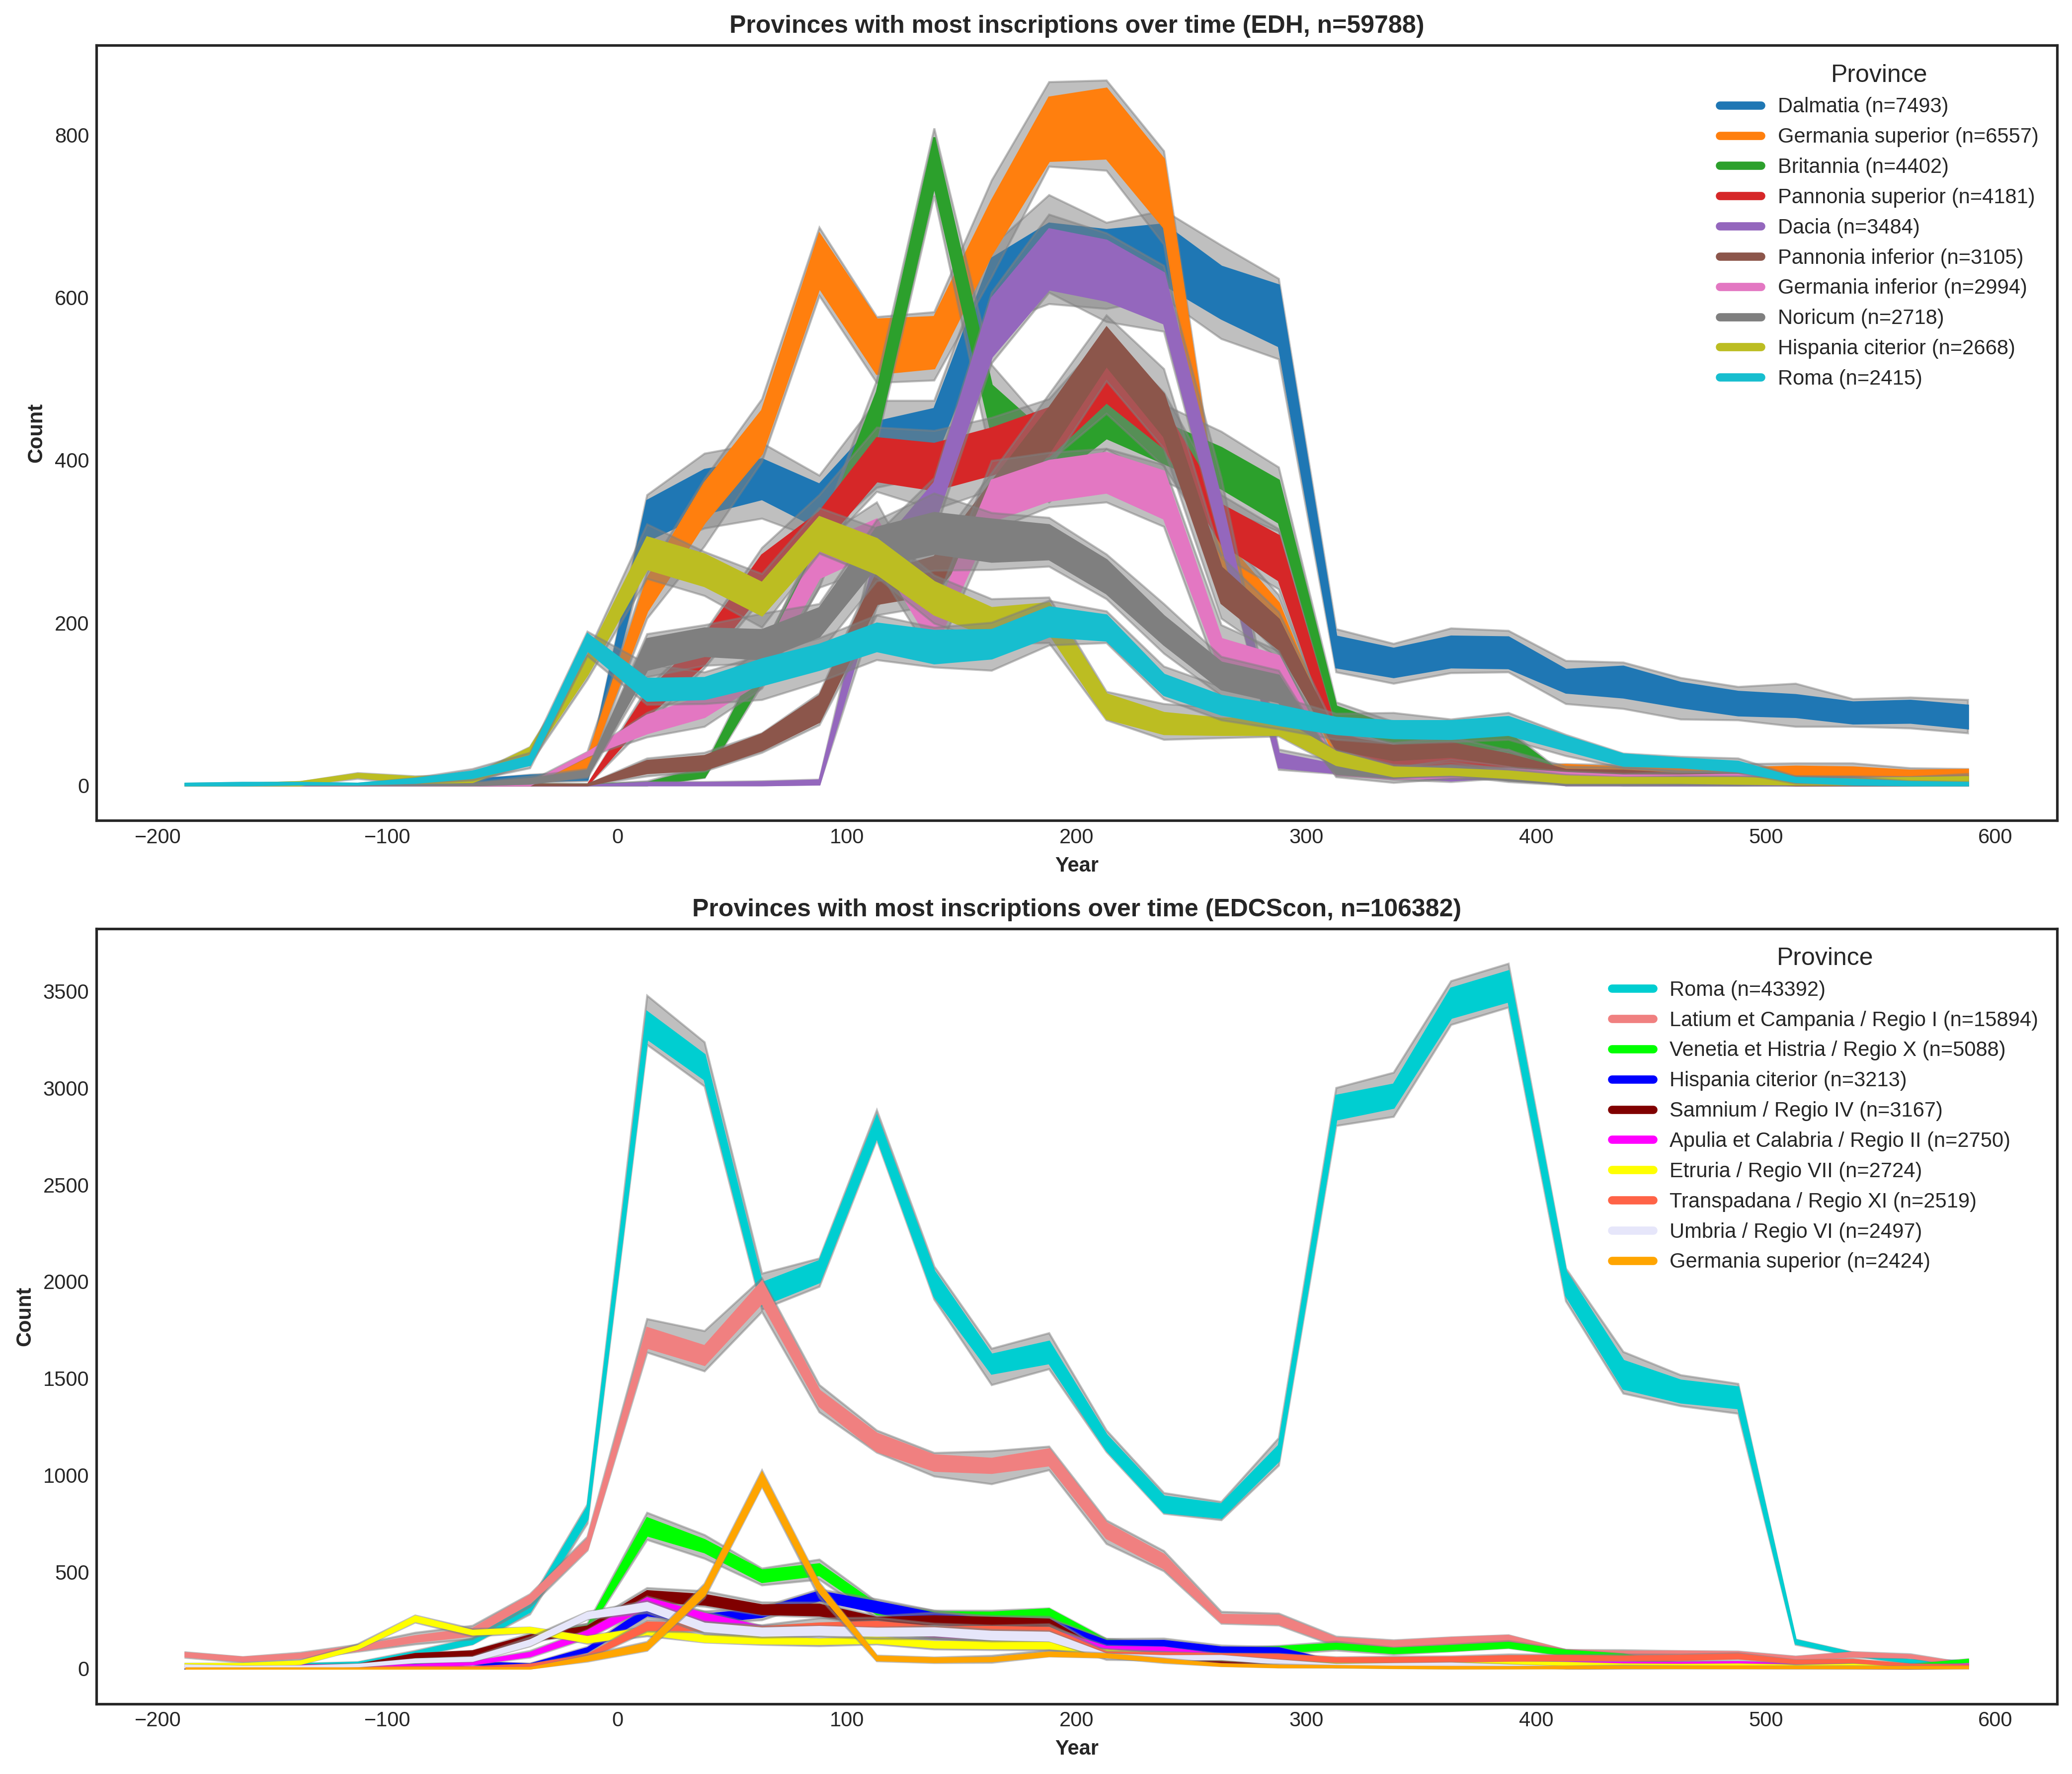

In [37]:
%%time
# Figure 4
# plot combining EDH and EDCScon
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(14, 12), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_prov_EDH, tab_colors_list[:len(simulations_by_prov_EDH)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax1, color=color)

ax1.set_xlabel("Year", weight="bold")
ax1.set_ylabel("Count", weight="bold")
ax1.set_title(f"Provinces with most inscriptions over time (EDH, n={len(EDH_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_prov_EDH)]]

legend_labels_prov_EDH = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_prov_EDH]

ax1.legend(markers, legend_labels_prov_EDH, numpoints=1,  
           title="Province", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

for ins_type_sims, color in zip(simulations_by_prov_EDCScon, tab_colors_list_prov_edcs):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax2, color=color)

ax2.set_xlabel("Year", weight="bold")
ax2.set_ylabel("Count", weight="bold")
ax2.set_title(f"Provinces with most inscriptions over time (EDCScon, n={len(EDCScon_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list_prov_edcs]

legend_labels_prov_EDCScon = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_prov_EDCScon]

ax2.legend(markers, legend_labels_prov_EDCScon, numpoints=1,
           title="Province", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

plt.savefig('Epigraphic_production_provinces.png')

Fig. 4: Eight Roman provinces with the most surviving inscriptions in the period between 200 BC to AD 600, as documented by EDH (n=59,788) and EDCScon (n=106,382) dataset. EDH inscriptions come mostly from provinces around the northern borders of the Roman Empire, while the majority of inscriptions in EDCScon was produced in Italic provinces or Hispania.

Most inscriptions in EDH come from the provinces on the northern border of Roman Empire, such as Britannia, both Germanias, Noricum, or from the Adriatic provinces, such as Dalmatia and Pannonias. However, the state of the data entry in EDH and its completeness may play an important role in the order of particular provinces and the trends of their production of inscriptions. As EDH states on its website, most of the provinces on the northern border of the Empire were entered fully, with the exception of data entry from Germanias and Belgica, where the data entry is still in progress. The provinces in Asia Minor, Northern Africa and in modern-day France are entered into the database only provisionally, and thus the data from EDH is not as representative for them as it is for other provinces.

The cacophony of lines in Figure 4 shows that epigraphic production in each of the eight provinces has a different trajectory. Historical circumstances, such as the date and manner of annexation to the Empire, affect the onset and steepness of each curve. The timing of pacification activities, movement of armies, settlement of new populations impact the 25-year trends in each province. The second half of the second century AD marks the highest levels of epigraphic production for most provinces except Britannia, where the production spikes in the first half of the second century AD and Noricum where the maximum sits at 100 AD. The province with the most numerous inscriptions is Dalmatia (n=7,493). Epigraphic tradition continues here even after AD 300, while in other provinces it almost disappears around AD 300. The decline of epigraphic production starts around AD 250 in both Germanias, Dacia and Pannonia Inferior, while other provinces, such as Dalmatia, Britannia and partially Panonnia Superior, record the main drop in production only after AD 300.

The majority of inscriptions in EDSCcon come from the centre of Roman Empire, from Italic provinces and Hispania. The province Roma, representing the territory of the capital Rome, produced by far the most dated inscriptions (n=43,392), followed by Latium and Campania (n=15,894). The epigraphic production in Rome sees three periods of growth of the total number of inscriptions: in the first half of the first century AD, around the middle of the second century AD and during the fourth century AD. Province `Latium et Campania` (n=15,894) follows a similar trend as Rome in the first and the second century AD, but not during the fourth century AD. The spatial proximity of both provinces suggests mutual influence on epigraphic trends, Latium being driven by the epigraphic activity of Rome during between the first and the third century AD.

#### Focused on Rome

Rome represents an outlier, compared to the epigraphic production in other provinces. The large number of inscriptions surviving in Rome represents 40 % of the entire EDCScon dataset, with the trends of epigraphic production being distinctive from the one in provinces. In order to better understand the factors contributing to the temporal distribution of the epigraphic production in Rome, we need to look at individual types of inscriptions over time. As EDH with only 2,556 dated inscriptions from Rome does not provide a representative overview in time, we use the EDCS dataset containing 43,392 dated inscriptions from Rome.

In [58]:
%%time
# Inscriptions from Rome
Roma_dated = EDCScon_dated[EDCScon_dated["province_list"]=="Roma"]

CPU times: user 42.5 ms, sys: 3.97 ms, total: 46.5 ms
Wall time: 43.5 ms


In [59]:
# Function to transform all inscription types into list form (originally it contains a lot of empty dictionaries etc.)
def clean_inscr_type(el):
    if isinstance(el, str):
        return [el]
    elif isinstance(el, dict):
        return []
    else:
        return el


Roma_dated["inscr_type_list_flat"] = Roma_dated["inscr_type"].apply(
    clean_inscr_type)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [60]:
inscr_types_flatlist_Roma = [
    el for ellist in Roma_dated["inscr_type_list_flat"].tolist() for el in ellist]
simulations_by_type_len_Roma = list(
    nltk.FreqDist(inscr_types_flatlist_Roma).most_common())
simulations_by_type_len_Roma

[('tituli sepulcrales', 33197),
 ('inscriptiones christianae', 20072),
 ('tituli fabricationis', 1258),
 ('tituli sacri', 1173),
 ('tituli operum', 713),
 ('carmina', 567),
 ('tituli possessionis', 399),
 ('tituli honorarii', 145),
 ('leges', 49),
 ('signacula', 30),
 ('termini', 17),
 ('defixiones', 13),
 ('reges', 8),
 ('senatus consulta', 2),
 ('diplomata militaria', 1)]

In [61]:
%%time
# Inscriptions by type over time

simulations_by_type_Roma = []

for ins_type_tup in simulations_by_type_len_Roma[:8]:
    subset_df = Roma_dated[Roma_dated["inscr_type_list_flat"].apply(
        lambda x: ins_type_tup[0] in x)]
    simulations = tempun.timeblocks_from_randoms(
        subset_df, "random_dates", [-200, 600, 25])
    ins_type_N = len(subset_df)
    simulations_by_type_Roma.append(
        [ins_type_tup[0], ins_type_N, simulations])

CPU times: user 3.48 s, sys: 15.7 ms, total: 3.5 s
Wall time: 3.49 s


CPU times: user 674 ms, sys: 241 ms, total: 916 ms
Wall time: 680 ms


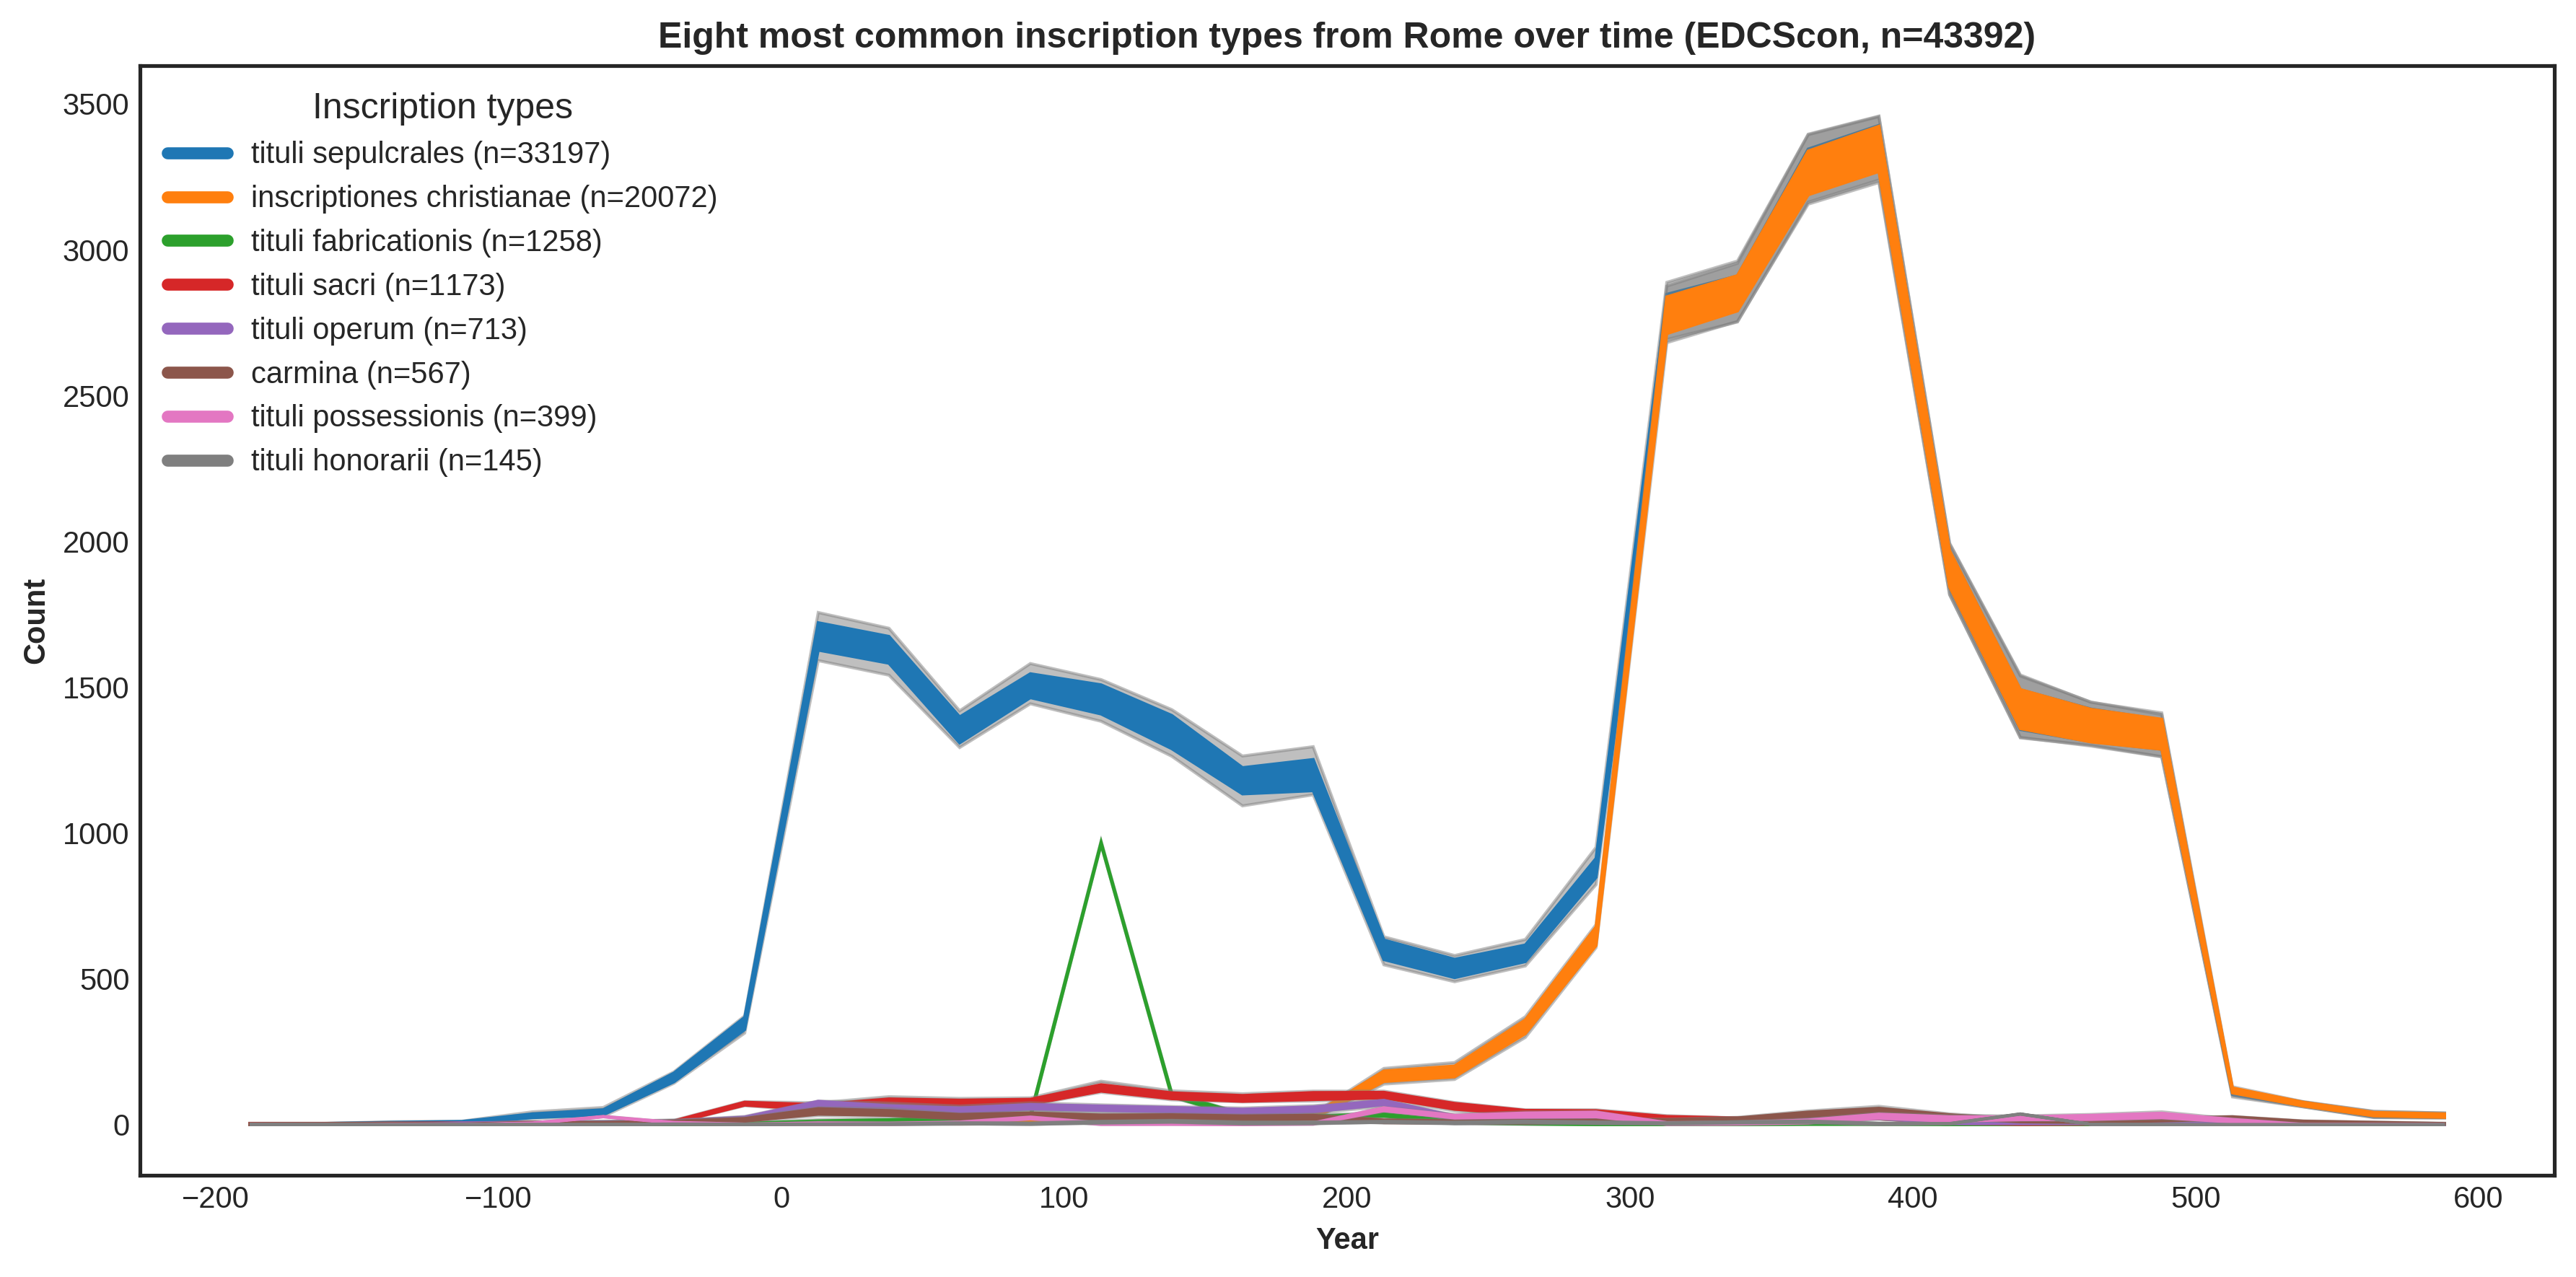

In [62]:
%%time
# Figure 5
# Plot inscriptions from Roma 
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

for ins_type_sims, color in zip(simulations_by_type_Roma, tab_colors_list[:len(simulations_by_type_Roma)]):
    tempun.plot_timeblocks_data(ins_type_sims[2], ax=ax, color=color)

ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title(f"Eight most common inscription types from Rome over time (EDCScon, n={len(Roma_dated)})", weight="bold")

markers = [plt.Line2D([0, 0], [0, 0], color=color, lw=4)
           for color in tab_colors_list[:len(simulations_by_type_Roma)]]

legend_labels_Roma = [tup[0] + " (n={})".format(str(tup[1])) for tup in simulations_by_type_Roma]

ax.legend(markers, legend_labels_Roma, numpoints=1,  
           title="Inscription types", title_fontsize="large", bbox_to_anchor=(0, 1), loc='upper left')

plt.savefig('Rome_Typologies_comparison_time.png')

Fig. 5: Typological distribution of epigraphic production from Rome in between 200 BC and AD 600, based on the EDCScon dataset (n=43,392). 

Figure 5 clearly demonstrates that 76.5 % of the epigraphic production from Rome, as recorded by EDCScon (n=43,392) is represented by funerary inscriptions. The trends of epigraphic production in Rome do not follow the classic pattern of *epigraphic habit*, not even if focused solely on the funerary inscriptions (`tituli sepulcrales`). Their number grew rapidly during the Augustan era (27 BC-14 AD), coinciding with the imperial expansion and the supply of quality marble from Carrara (Bodel 2001, 7). The production remained relatively stable until the second half of the second century AD. The third century AD sees a drop in production of funerary inscriptions, that is around AD 300 followed by a substantial increase of the number of inscriptions, caused by the production of Christian funerary inscriptions, i.e. inscriptions which are classified both as `tituli sepulcrales` and `inscriptiones christianae`. The inscriptions, labelled as Christian, form the second most numerous typological group in Rome (n=20,072). They start to grow around AD 200, but they gain substantial popularity in AD 300. They continue to be produced in large numbers between 3000 and 3500 inscriptions per 25 years until AD 400, when their production drops approximately 50 %, and it sharply declines and almost disappears after AD 500 (Bodel 2001, 6). The trends of production of Christian inscriptions in Rome are contemporary with the building and use of catacombs as a place of funerary rites and a final resting place for Christians (Trout 2009, 175). Yet, as Trout and others correctly point out, the Christian and Late Antiquity inscriptions are published and studied in separately from the pre-Constantian inscriptions and thus are likely underrepresented in sources such as EDH or EDCS (Trout 2009, 171; Roueché and Sotinel 2017, 503-507).

Rather irregular pattern can be observed in EDCS dataset with `tituli fabricationis`, ie. inscriptions related to the manufacturing process, also including an artist’s signature or workshop stamps (`sigilla impressa`). Almost all the `tituli fabricationis` from Rome come from the first quarter of the second century AD and are made on pottery (84 %), or lead (11.7 %). The concentration of `tituli fabricationis` in Rome in the first quarter of the second century AD most likely does not suggest an increasing production of pottery in Rome at that time, or the sudden change of approaches toward the cultural norms around pottery manufacturing, but it rather corresponds with the archaeological discovery of one or more workshops and subsequent documentation of their stamped products by EDR and EDCS (e.g., Bloch 1947; 1967).

Having the data in comparable format, we were able to get a more nuanced image of the development in time within regional political subunits, potentially showing local variations within the epigraphic production, but also border responses to contemporary societal development. However, the level of interoperability between datasets, as well as their state of data entry, and their regionalised data collection become a factor seriously impacting any meaningful outcome.

## Discussion: The Great Expectations of Digital Epigraphy

> Here will be one paragraph of text.

Quantitative research using historical data will always provide a wide range of technological and methodological challenges. Even though digital datasets may be published and available online,  digital form does not make them immediately accessible and analysis-ready, let alone interoperable and with harmonized metadata. Contrary to expectations, it takes a considerable effort to shape digital data, or rather digitized representations of analog materials, into the right form, that both computers and humans can make sense of. 

The epigraphic community has done a tremendous amount of work creating both datasets for Latin epigraphy, Epigraphic database Heidelberg (EDH) and Epigraphic Database Clauss-Slaby (EDCS). Not only did they collect and digitize printed records, but standardized them creating one universally accepted EpiDoc XML/TEI format (Bodard 2008; Cayless et al. 2010; Elliott et al. 2020). The great effort put into digitising and publishing resources online, however, still sees a limited outcome in the form of quantitative studies as the databases often lack interoperability (Avanzini et al. 2018). The initiative started by the EAGLE Europeana project and further fueled by the professional community around Epigraphy.info is working on the solution truly enabling quantitative and interconnected research in epigraphy (Liuzzo 2018; Bodard et al. 2021). However, the lack of financial support for transnational research infrastructure hinders any substantial progress that is currently powered by individuals volunteering their time and effort. Until the field can come up with a sustainable solution for linking various epigraphic databases, as proposed by the Epigraphy.info community (Feraudi-Gruénais and Grieshaber 2016), the outcomes of any quantitative research in epigraphy will highly depend on the selection of the dataset.

As demonstrated by the current article, the visualisations of *epigraphic habit(s)* of Latin publishing communities and the resulting models of epigraphic production highly depend on the choice of source and the method of data preprocessing and analysis. Although both presented datasets stem from the same idea and have seemingly the same purpose, their spatial and temporal coverage differs quite substantially and thus they both produce different images of epigraphic activity throughout the Roman Empire in space and time. EDH dataset focuses predominantly on data from the Roman provinces along the Northern borders of the Empire. Thus, unsurprisingly, the highest levels of epigraphic activity in EDH during the second century AD coincide with the times of rapid socio-economic development along the northern parts of Limes Romanus (Verhagen et al. 2016, 313; Hanel 2020; Kemkes 2020). The records in EDCS, on the other hand, are centered around Rome and Italic provinces, showing the highest levels of epigraphic activity in the Augustan and Flavian era in the first century AD and in the fourth century AD, reflecting the building activities in Rome, or underneath respectively (Bodel 2001, 7; Trout 2009, 171).

The use of digital tools and statistical modelling allows us to produce reproducible results and handle large amounts of data efficiently. Digital solutions help us overcome the technical challenge of placing the inscriptions on a temporal axis, plotting them on a map, and quantifying their number as well as other attributes, such as typologies, material and others. By rendering the data comparable, we solved some technical and methodological issues only to be present with new interpretive and conceptual problems. We now need to interrogate more deeply and explain the new multitude of trends, we need to zoom in on the gaps and biases in these ‘big data‘ and assess their suitability for different research questions. Now that the technical problems have subsided, we can finally focus on the genuine empirical question of epigraphic habit and open it up to the broader community of historians and epigraphers.

Before anyone can provide a satisfactory answer to what were the main motivations of epigraphic production and why they were more prevalent in certain times or areas, we, as a community, need to be able to locate inscriptions in place, and most importantly in time. While the spatial aspect has been solved reasonably well with the use of spatial gazetteers and Linked Open Datasets (LOD), the temporal classification of inscriptions, however, contains a large degree of uncertainty and fuzziness, making any comparative study dependent on computational solutions (Rabinowitz et al. 2018, 203-204). To be able to interrogate the data in a truly holistic manner, across numerous digital resources, the community has to continue promoting interoperability of digital resources and building a sustainable research infrastructure.

Given the current wave of support of the digital epigraphy projects, such as the ECR funded projects [Patrimonium](https://patrimonium.huma-num.fr/) (2017-2022), [LatinNow](https://latinnow.eu/) (2017-2022), [Mappola](https://mappola.eu/) (2019-2024), [Crossroads](https://crossreads.web.ox.ac.uk/) (2020-2025), or ITN-ESR funded [Carmen](https://carmen-itn.eu/) (since 2020), we are hopeful that in the not-so-distant future the community will collaborative solve the interoperability issues for all. There is a chance that before 2030, we will be finally able to interrogate the material and answer the questions that have been bothering epigraphers and historians since the time of Ramsey MacMullen in 1980’s (Macmullen 1982). But before that, more effort has to be put into building sustainable and FAIR solutions, creating links between the existing datasets and providing low threshold entry pathways to digital research, should digital epigraphy become accessible to the wider community.

## Building a Research Pipeline for FAIR and Open Digital Epigraphy
In the current section, we target primarily the first stages of the research lifecycle, such as data-access and streamlining phase as a key and formative aspect of any historical analysis, that is however often made peripheral in favour of analysis and discussion of results. We document the full research lifecycle of work with digital historical datasets in a series of scripts in R and Python, with primary focus on transparency and reproducibility in order to promote scientific collaboration and advance the historical discipline. 

We decided to use established tools and solutions, such as [Github](https://github.com/sdam-au/) for code storage and version control, https://sciencedata.dk/ as operational data storage, Zenodo for data publication and archivation. Where we lacked existing tool, we built our own, such as the [sddk](https://pypi.org/project/sddk/) Python package and sdam::request function within the [sdam R](https://github.com/sdam-au/sdam) package to access the storage space on Sciencedata.dk from within our respective coding environment. By developing such tools, we were able to prevent any data duplication, while enhancing the collaboration between Python and R users. 

### Step 1: Data access & collection stage
Both EDH and EDCS provide a different pathway to the data, bringing both technological and ethical issues that are common to researchers working with digital archives. We have approached the data collection part of the research life-cycle as transparent and FAIR as possible and documented the entire process in a series of Python scripts.


#### Working with open datasets

The path to the EDH dataset was relatively straightforward since the authors have provided direct accesspoint to the data via ([API](https://edh-www.adw.uni-heidelberg.de/data/api)) on their website. Moreover, they have clearly stated the conditions of use the data by providing the [CC BY-SA 4.0 Creative Commons License](https://edh-www.adw.uni-heidelberg.de/data). We will briefly summarize the steps undertaken and link to the relevant scripts.

First, we accessed the Geography API, containing geospatial information of the findspots of inscriptions, and created a json file containing geospatial coordinates and names of individual places. For details see the Python script [1_0_py_EXTRACTING-GEOGRAPHIES.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_0_py_EXTRACTING-GEOGRAPHIES.ipynb)

As a second step, we extracted all inscriptions and their metadata from the EDH API and saved them as a json file, see details in the Python script [1_1_py_EXTRACTION_edh-inscriptions-from-web-api.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_1_py_EXTRACTION_edh-inscriptions-from-web-api.ipynb).

As a third step, we have extracted additional information that was not present in the APIs from EpidocXML files into a separate json, using the Python script [1_2_py_EXTRACTION_edh-xml_files.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_2_py_EXTRACTION_edh-xml_files.ipynb) to ensure we are not missing any crutial piece of information.

Next, we have merged all the three json files and created an enriched json file containg raw data, using the Python script [1_3_py_MERGING_API_GEO_and_XML.ipynb](https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_3_py_MERGING_API_GEO_and_XML.ipynb). The enriched dataset, containing data from APIs as well as XML files was later streamlined and cleaned by a series of R scripts, for details see section on Data cleaning (Step 2).

#### When the resource was not built as open

When accessing the EDCS dataset we have encountered issues common to any digital researcher. As mentioned above, EDSC web interface is the only gateway to the data but it does not provide an API, nor it saves search results in a reproducible manner. Thus, we have decided to use a Python based digital tool, built with the permission of Manfred Clauss, and in collaboration with researchers at Macquarie University in Australia (Ballsun-Stanton et al., 2020; https://github.com/mqAncientHistory/EpigraphyScraperNotebook).
The tool accesses programmatically the web interface of EDCS and saves the search output as a CSV file, along with the metadata of a search query preserved in the name of the file in a reproducible manner. Moreover, the tool produces a separate file with the search results mapped along with the system of Roman Provinces and road network, using the [Digital Atlas of Roman and Medieval Civilizations (DARMC)](https://darmc.harvard.edu/) and [Pleiades](https://pleiades.stoa.org/) open datasets of the ancient Mediterranean for easy and quick visualisation of the search query. The main purpose of the tool is to alleviate some of the technological and methodological inefficiencies of EDCS and enable reproducible and quantitative research of Latin inscriptions, in a way that EDH does.
 

### Step 2: Data cleaning & streamlining

Unfortunately, having the data accessible does not often mean they are in the format required by the software or the researcher (Borgman 2015). Often the dataset there were not born-digital, but rather digitised contain typos, inconsistencies, attributes are entered incorrectly or data are missing. Trying to programmatically, let alone manually, solve these issues consumes most of the time dedicated to research. However, this crucial stage of data stewardship is often disregarded in academic publications, but also when planning and budgeting research projects. 


In order to mitigate the impact of having to streamline a large amount of imperfect data, we have created four R scripts dealing specifically with cleaning of attributes containing metadata information and epigraphic text. This way, we were able to clean almost thirteen attributes for all the 81,476 records of the EDH dataset, resulting in streamlining of 1,059,188 original values. In the EDCS dataset, we have streamlined six attributes for all 500,536 records, resulting in changes made to 3,003,216 original values. Tasks that would take years of manual editing took approximately three months to complete, including extensive testing and iterative improvements to all four cleaning scripts. In the end we have two large datasets that are ready to be analysed, but we have also created a reproducible and transparent pipeline for transformation of epigraphic data that can be applied to other research projects.

#### Attribute cleaning and conflation of information

* Script for EDH dataset: https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_4_r_DATASET_ATTRIBUTES_CLEANING.Rmd  
* Script for EDCS dataset: https://github.com/sdam-au/EDCS_ETL/blob/master/scripts/1_1_r_EDCS_merge_clean_attrs.Rmd 

As the first stage of the cleaning phase, we needed to streamline the metadata attributes that often conflate multiple types of information into one. The multiple types of information stored in one attribute go against the principles of data normalization and make any computerized operations difficult, if not impossible. We decided to separate the types of information into new attributes, but keep the original attributes as a control mechanism. However, this way we expanded the size of the original dataset from 51 attributes to 71 in the case of EDH, and from 15 to 27 for the EDCS dataset.

We demonstrate the cleaning process on the `type_of_inscription` attribute in EDH, containing unconstrained textual description of the typological category of an inscripription and information about certainty of such categorisation. We have created new attributes containing only the information about the typology of inscriptions in one (type_of_inscription_clean) and the certainty information in other (type_of_inscription_certainty). This way we have reduced the number of typological variants by 47,7 % from 44 to 23, making any comparisons and calculations straightforward, while keeping the level of uncertainty connected with the typological classification of inscription separate and ready to be quantified.


#### Step 2.2: Regular Expressions as historian's best friend

When dealing with unstructured text, we heavily rely on the use of Regular Expressions as the most efficient yet simple tool for pattern matching (e.g., https://regex101.com/; packages stringr for R and gsub function in base R). We search for repetitive patterns in the text of the attributes, in order to separate different pieces of information so they can be easily computationally accessed in the later stages of the analysis. To illustrate our approach, we extract information providing a level of spatial uncertainty related to the findspot of an inscription from the textual descriptions of the place.

The attribute findspot_ancient in EDH contained textual descriptions of the original findspot, with specifications of the level of certainty connected to a particular place name, e.g. “Cumae, bei”, "Roma?", "Emerita Augusta, aus", "Bracara Augusta - Lucus Augusti, inter", "Epidotium - Ancus, zwischen". By eliminating the marker of uncertainty from the findspot_ancient we have managed to streamline the attribute by 35 %: the attribute before cleaning contained 3613 unique values, after cleaning we have 2342 unique values of ancient findspot. In order to preserve the information about the level of uncertainty connected with the findspot location, we have then created a new attribute (finsdpot_ancient_certainty) containing categorical values corresponding with the certainty of localization. This way we were able to extract the measure of uncertainty from all records, save it as a separate piece of information for future use.

#### Step 2.3: Cleaning of epigraphic text

* Script for EDH dataset: https://github.com/sdam-au/EDH_ETL/blob/master/scripts/1_5_r_TEXT_INSCRIPTION_CLEANING.Rmd  
* Script for EDCS dataset: https://github.com/sdam-au/EDCS_ETL/blob/master/scripts/1_2_r_EDCS_cleaning_text.Rmd

Similarly as the attributes containing metadata have to be transformed to be suitable for computer assisted analysis, we had to streamline the attribute containing the text of an inscription. The text of inscriptions from EDH and EDCS contained extra text not present on the original medium, as well as the symbols preventing the distant reading methods from producing any meaningful output. The symbols and various types of brackets are marked up in accordance with Leiden epigraphic conventions communicating the rate of preservation of the text, the level of modern restoration or additional features of the text, such as interpunction or decoration (Dow 1969; McLean 2003, 27-39; Elliott et al. 2020). However useful the Leiden markup system for study of individual inscriptions and their historical significance, it is highly problematic for any quantified study. Human brain is capable of parsing information differently than a computer and what might be straightforward for an epigrapher when reading an inscription with Leiden markup, proves to be a complex task for a computer. To give you an example, the human brain knows the text `[Au]relios` is the same as the word `Aurelios` with no markup. However, for computers `[Au]relios` and `Aurelios` are two different words and thus would be considered as two separate instances.

Our proposed technical solution eliminates the Leiden markup syntax in a systematic way and produces three different versions of the text designed specifically for their intended type of analysis. We have created a series of RegEx cleaning blocks, that solve one type of markup at the time, and then we have built them in a cleaning function producing the desired outcome for the analysis of text. The Leiden markup in EDCS slightly deviated from the standard application, providing its own specific syntax, e.g. `[3]` for blank space within a line or `[6]` for blank line. Thus the cleaning script had to be slightly modified to fit the specifics of EDCS. The sequence of the blocks in the cleaning functions was built specifically for individual datasets and type of intended analysis, but the cleaning blocks were designed rather generically and can be used to clean any text marked according to the Leiden markup conventions, where EpiDoc XML/TEI files are not available, such as the case of EDCS, and thus application of XSLT based transformation is not an option (Elliott et al. 2017). 

Example of a text of an inscription (EDH HD000003) before cleaning, including Leiden markup syntax: 

`'[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eria) S]isenna[e Ru]/[tiliano] Xv[ir(o) stli]/[tibus iudicandis ---] / [------'`
The text of an inscription was transformed into two main versions:
A conservative version of the text, contained in the attribute `clean_text_conservative`. The aim of the conservative text was to have a text with no markup that is as close to the original inscription as preserved on the durable medium, similar in output as the diplomatic/ majuscule edition in EDH.
`'ummio isenna Xv'`

An interpretive version of the text, contained in the attribute `clean_text_interpretive`. The interpretive version contains the original text as preserved on a medium enriched with editorial interpretations, expanded abbreviations, and reconstructions of the text in order to achieve as rich text of an inscription as possible. For the purpose of text analysis, we have created two versions of the interpretive text:
one with no interpunction between sentences (clean_text_interpretive_word)
one with preserved interpunction separating individual sentences (clean_text_interpretive_sentence), only applied to EDH dataset.

`'Publio Mummio Publi filio Galeria Sisennae Rutiliano X viro stlitibus iudicandis'`

The cleaning process was designed with the intention of distant text reading and quantitative analysis of textual contents of inscriptions and therefore it might not be useful or relevant for studies based on a close-reading of texts.  The cumulative length of texts of all inscriptions in EDH before cleaning was between 1.81 to 1.89 million words, depending on the counting method (base R vs [stringr package](https://CRAN.R-project.org/package=stringr) in R). After the cleaning, the text of all inscriptions contained between 1.14 and 1.22 million words. In the case of the EDCS dataset, the text attribute before the cleaning contained between 7.1 and 6.6 million words, depending on the applied counting method (base R vs stringr package in R). After the cleaning the text attribute contained between 4.6 and 4.06 million words. 



#### Step 2.4: Residual cleaning of EDCS inconsistent HTML markup
The cleaning procedure for EDCS dataset was more entailed as the attribute inscription, that was produced by the digital tool accessing the EDCS database, contained apart from the text of an inscription in some records also commentary, notes to chronology, bibliographical references and other text, not present on the original inscribed medium. The mixup of the data was caused by the structure of the original EDCS website that was using the same HTML tags for the text of an inscription, its commentary and in some cases alternate dates. However, the tags were not used consistently for all inscriptions, so tool-wide modifications would not have been helpful. Thus, before we could clean the epigraphic text, we needed to separate the text of an inscription and the non-epigraphic text in a transparent and reproducible way. We developed an additional cleaning function in the [EDCS text cleaning script](https://github.com/sdam-au/EDCS_ETL/blob/master/scripts/1_2_r_EDCS_cleaning_text.Rmd), using Regular Expressions in a specific sequence to extract the redundant information, separate it by category and add to the original dataset. During the separation process, we have managed to process 1268 inscriptions, representing 0.25 % of the entire dataset in a fraction of time that it would have taken a human to go through all the records and search for potential issues one-by-one. As a direct benefit of the scripted cleaning process to the epigraphic community, we are now able to report back to the creators of the tool accessing the EDCS the ID numbers of problematic records so the tool can be fixed for future researchers.
